# Football

This notebook is an example on how to use the VerticaPy Library. We will use the Football dataset to predict the games issues. You can download the Jupyter Notebook of the study by clicking <a href="football.ipynb">here</a>. To achieve our goals, we have access to the following data. 
<ul>
    <li><b>date: </b>Date of the game</li>
    <li><b>home_team: </b>Home Team</li>
    <li><b>home_score: </b>Home Team number of goals</li>
    <li><b>away_team: </b>Away Team</li>
    <li><b>away_score: </b>Away Team number of goals</li>
    <li><b>tournament: </b>Game Type (World Cup, Friendly...)</li>
    <li><b>city: </b>City where the game took place</li>
    <li><b>country: </b>Country where the game took place</li>
    <li><b>neutral: </b>If the event took place to a neutral location</li>
</ul>
The CSV file of the dataset is available by clicking <a href="../../data/football.csv">here</a>.
We will follow the entire Data Science cycle (Data Exploration - Data Preparation - Data Modeling - Model Evaluation - Model Deployment) and solve this easy use-case. The purpose is to show you some of the library interesting functionalities.

## Initialization

Let's create a Virtual DataFrame of the dataset.

In [1]:
from verticapy import *
football = vDataFrame("public.football")
football.head(5)

,tournament,away_team,away_score,neutral,country,city,date,home_score,home_team
0,Friendly,England,0,False,Scotland,Glasgow,1872-11-30,0,Scotland
1,Friendly,Scotland,2,False,England,London,1873-03-08,4,England
2,Friendly,England,1,False,Scotland,Glasgow,1874-03-07,2,Scotland
3,Friendly,Scotland,2,False,England,London,1875-03-06,2,England
4,Friendly,England,0,False,Scotland,Glasgow,1876-03-04,3,Scotland
,...,...,...,...,...,...,...,...,...


<object>  Name: football, Number of rows: 41586, Number of columns: 9

## Data Exploration

Let's explore the data by displaying descriptive statistics of all the columns.

In [2]:
football["date"].describe()

,value
name,"""date"""
dtype,date
count,41586
min,1872-11-30
max,2020-02-01


<object>

The dataset includes 41586 games which took place between 1872 and 2020. Let's look at the different types of games and information about the teams.

In [3]:
football["tournament"].describe()

,value
name,"""tournament"""
dtype,varchar(84)
unique,112.0
count,41586.0
Friendly,17029
Others,10630
FIFA World Cup qualification,7236
UEFA Euro qualification,2582
African Cup of Nations qualification,1672
FIFA World Cup,900


<object>

Different types of tournaments took place (FIFA World Cup, UEFA Euro ...). Most of the games are Friendly or qualifications to international tournaments.

In [4]:
print(football.describe())
football.describe(method = "categorical")

,count,mean,std,min,25%,50%,75%,max,unique
away_score,41586,1.18758716875872,1.40532346833589,0.0,0.0,1.0,2.0,21.0,22.0
home_score,41586,1.74575578319628,1.75378034047699,0.0,1.0,1.0,2.0,31.0,26.0
neutral,41586,0.247246669552252,0.431416538275649,0.0,0.0,0.0,0.0,1.0,2.0


<object>


,dtype,unique,count,top,top_percent
"""tournament""",varchar(84),112,41586,Friendly,40.949
"""away_team""",varchar(64),305,41586,Uruguay,1.301
"""away_score""",int,22,41586,0,37.135
"""neutral""",boolean,2,41586,False,75.275
"""country""",varchar(64),266,41586,United States,2.787
"""city""",varchar(56),2013,41586,Kuala Lumpur,1.416
"""date""",date,15196,41586,2012-02-29,0.159
"""home_score""",int,26,41586,1,29.57
"""home_team""",varchar(64),308,41586,Brazil,1.366


<object>

The dataset includes 308 national teams. For most of the games, the home team score is greater than the away team score. As some games could take place in a neutral location, we can ensure this hypothesis using the variable 'neutral'. We can also notice that the number of goals per match is pretty low (median of 1 for the away and the home team). 

<b>Problematic :</b>

During this study, we will try to predict the games issues which took place after 2015.

Before doing the study, we can notice that some teams names changed during the time due to the past events. We need to change the old names by the new names otherwise it will add too much bias in the data.

In [5]:
name = {"German DR": "Germany",
        "Czechoslovakia": "Czech Republic",
        'Yugoslavia': 'Serbia',
        'Yemen DPR': 'Yemen'}
name = ["'{}', '{}'".format(i, name[i]) for i in name]
name = ", ".join(name)
football["home_team"].apply("DECODE({}, " + name + ", {})")
football["away_team"].apply("DECODE({}, " + name + ", {})")

,tournament,away_team,away_score,neutral,country,city,date,home_score,home_team
0,Friendly,England,0,False,Scotland,Glasgow,1872-11-30,0,Scotland
1,Friendly,Scotland,2,False,England,London,1873-03-08,4,England
2,Friendly,England,1,False,Scotland,Glasgow,1874-03-07,2,Scotland
3,Friendly,Scotland,2,False,England,London,1875-03-06,2,England
4,Friendly,England,0,False,Scotland,Glasgow,1876-03-04,3,Scotland
,...,...,...,...,...,...,...,...,...


<object>  Name: football, Number of rows: 41586, Number of columns: 9

We will also only consider the teams which had played more than 5 games at home and away.

In [6]:
football.eval(name = "cnt_games_1",
              expr = "COUNT(*) OVER (PARTITION BY home_team)")
football.eval(name = "cnt_games_2",
              expr = "COUNT(*) OVER (PARTITION BY away_team)")
football.filter("cnt_games_2 > 5 AND cnt_games_1 > 5")
drop_table("football_clean")
football.to_db(name = "football_clean",
               usecols = ["date", 
                          "home_score", 
                          "home_team", 
                          "tournament", 
                          "away_team", 
                          "away_score", 
                          "neutral", 
                          "country",
                          "city"],
               relation_type = "table",
               inplace = True)

177 element(s) was/were filtered
The table football_clean was successfully dropped.


,date,home_score,home_team,tournament,away_team,away_score,neutral,country,city
0,2014-06-02,1,Sápmi,CONIFA World Football Cup,Abkhazia,2,False,Sweden,Östersund
1,2019-06-03,0,Sápmi,CONIFA European Football Cup,Abkhazia,1,True,Azerbaijan,Martakert
2,2017-06-10,3,Székely Land,CONIFA European Football Cup,Abkhazia,1,True,Northern Cyprus,Kyrenia
3,2014-06-05,3,Padania,CONIFA World Football Cup,Abkhazia,3,True,Sweden,Östersund
4,2017-06-09,0,Padania,CONIFA European Football Cup,Abkhazia,0,True,Northern Cyprus,Kyrenia
,...,...,...,...,...,...,...,...,...


<object>  Name: football_clean, Number of rows: 41409, Number of columns: 9

Many indicators could possibly influence a game issue. By having access only to the game score, teams and types of confrontation, we can not use external factors (game temperature, players shapes...) which could help our prediction. To create a good model using this dataset, an idea could be to compute teams KPIs (percent victory at home, number of victory in the last games...), ranking (clusters computed using the number of games in important tournaments like the World Cup, the percentage of victory...), shape (moving windows using the last games information) and other interesting features.

To achieve our goals, we will use the following plans.
<ul class="ul_param">
    <li>Finding the Cups Winners</li>
    <li>Ranking the Teams using Clustering</li>
    <li>Computing teams KPIs</li>
    <li>Creating a ML model</li>
</ul>

## Data Preparation for Clustering

To obtain robust and significant clusters, we need to find which teams are the winners of main tournaments (mainly the World Cups and Continental Cups). As all the tournaments took place the same year, an idea could be to use a partition by tournament and year to identify the last game of the tournament. In case of tie game, we can not easily find the winner. That's why, we decided to skip these games.

### Cups Winner

Let's first create the feature 'winner' (game winner).

In [7]:
football.filter("YEAR(date) <= 2015")
football.case_when(name = "winner",
                   conditions = {"home_score > away_score": "home_team",
                                 "home_score < away_score": "away_team"},
                   others = None,
                   auto_quote = False)

3884 element(s) was/were filtered


,date,home_score,home_team,tournament,away_team,away_score,neutral,country,city,winner
0,1872-11-30,0,Scotland,Friendly,England,0,False,Scotland,Glasgow,None
1,1873-03-08,4,England,Friendly,Scotland,2,False,England,London,England
2,1874-03-07,2,Scotland,Friendly,England,1,False,Scotland,Glasgow,Scotland
3,1875-03-06,2,England,Friendly,Scotland,2,False,England,London,None
4,1876-03-04,3,Scotland,Friendly,England,0,False,Scotland,Glasgow,Scotland
,...,...,...,...,...,...,...,...,...,...


<object>  Name: football_clean, Number of rows: 37525, Number of columns: 10

We can then look at the tournament last game using advanced analytical features.

In [8]:
football.eval(name = "year",
              expr = "YEAR(date)")
football.analytic('row_number', 
                  order_by = {"date": "desc"}, 
                  by = ["tournament", "year"] , 
                  name = "order_tournament")

,date,home_score,home_team,tournament,away_team,away_score,neutral,country,city,winner,year,order_tournament
0,2011-12-04,2,Suriname,ABCS Tournament,Curaçao,0,False,Suriname,Paramaribo,Suriname,2011,1
1,2011-12-04,2,Bonaire,ABCS Tournament,Aruba,2,True,Suriname,Paramaribo,None,2011,2
2,2011-12-02,1,Curaçao,ABCS Tournament,Bonaire,3,True,Suriname,Paramaribo,Bonaire,2011,3
3,2011-12-02,0,Suriname,ABCS Tournament,Aruba,0,False,Suriname,Paramaribo,None,2011,4
4,2013-11-16,1,Curaçao,ABCS Tournament,Suriname,3,False,Curaçao,Willemstad,Suriname,2013,1
,...,...,...,...,...,...,...,...,...,...,...,...


<object>  Name: football_clean, Number of rows: 37525, Number of columns: 12

We can filter the data by only considering the last games and top tournaments. 

In [9]:
football.filter(conditions = ["order_tournament = 1",
                              "winner IS NOT NULL",
                              "tournament IN ({})".format(
                                  ", ".join(["'FIFA World Cup'", 
                                             "'UEFA Euro'", 
                                             "'Copa América'", 
                                             "'African Cup of Nations'",
                                             "'AFC Asian Cup'",
                                             "'Gold Cup'"]))])

37418 element(s) was/were filtered


,date,home_score,home_team,tournament,away_team,away_score,neutral,country,city,winner,year,order_tournament
0,1956-09-15,5,South Korea,AFC Asian Cup,Vietnam Republic,3,True,Hong Kong,So Kon Po,South Korea,1956,1
1,1960-10-21,1,South Korea,AFC Asian Cup,Chinese Taipei,0,False,South Korea,Seoul,South Korea,1960,1
2,1964-06-03,2,Israel,AFC Asian Cup,South Korea,1,False,Israel,Ramat-Gan,Israel,1964,1
3,1968-05-19,2,Iran,AFC Asian Cup,Israel,1,False,Iran,Teheran,Iran,1968,1
4,1972-05-19,2,Iran,AFC Asian Cup,South Korea,1,True,Thailand,Bangkok,Iran,1972,1
,...,...,...,...,...,...,...,...,...,...,...,...


<object>  Name: football_clean, Number of rows: 107, Number of columns: 12

Let's consider the World Cup as a special tournament. It is the only one where the confrontations between the top teams is possible. 

In [10]:
football.eval(name = "Word_Cup", 
              expr = "DECODE(tournament, 'FIFA World Cup', 1, 0)")

,date,home_score,home_team,tournament,away_team,away_score,neutral,country,city,winner,year,order_tournament,Word_Cup
0,1956-09-15,5,South Korea,AFC Asian Cup,Vietnam Republic,3,True,Hong Kong,So Kon Po,South Korea,1956,1,0
1,1960-10-21,1,South Korea,AFC Asian Cup,Chinese Taipei,0,False,South Korea,Seoul,South Korea,1960,1,0
2,1964-06-03,2,Israel,AFC Asian Cup,South Korea,1,False,Israel,Ramat-Gan,Israel,1964,1,0
3,1968-05-19,2,Iran,AFC Asian Cup,Israel,1,False,Iran,Teheran,Iran,1968,1,0
4,1972-05-19,2,Iran,AFC Asian Cup,South Korea,1,True,Thailand,Bangkok,Iran,1972,1,0
,...,...,...,...,...,...,...,...,...,...,...,...,...


<object>  Name: football_clean, Number of rows: 107, Number of columns: 13

We can compute all the number of cups by team. As expected, Brazil and Germany are the top football teams.

In [11]:
agg = ["SUM(Word_Cup) AS nb_World_Cup",
       "SUM(1 - Word_Cup) AS nb_Continental_Cup"]
football_cup_winners = football.groupby(["winner"], agg)
football_cup_winners.sort({"nb_World_Cup": "desc",
                           "nb_Continental_Cup": "desc"}).head(10)

,winner,nb_World_Cup,nb_Continental_Cup
0,Brazil,4,8
1,Germany,4,3
2,Italy,3,1
3,Argentina,2,8
4,Uruguay,2,8
5,Spain,1,3
6,France,1,2
7,England,1,0
8,Mexico,0,6
9,Egypt,0,5


<object>  Name: groupby, Number of rows: 40, Number of columns: 3

Let's export the result to the Database.

In [12]:
drop_table("football_cup_winners")
football_cup_winners.to_db("football_cup_winners", 
                           relation_type = "table")

The table football_cup_winners was successfully dropped.


,winner,nb_World_Cup,nb_Continental_Cup
0,Brazil,4,8
1,Germany,4,3
2,Italy,3,1
3,Uruguay,2,8
4,Argentina,2,8
,...,...,...


<object>  Name: groupby, Number of rows: 40, Number of columns: 3

### Teams Confederation

Finding the teams confederations could be interesting. We could understand skills differences between the different continents. A team which had played a qualification of a specific location can only belong to the tournament confederation.

First let's encode the different continents to be able to compute the correct aggregations.

In [13]:
football = vDataFrame("football")
football.case_when('confederation' , 
                   {"tournament = 'UEFA Euro qualification'": 5,
                    "tournament = 'African Cup of Nations qualification'": 4,
                    "tournament = 'AFC Asian Cup qualification'": 3,
                    "tournament = 'Copa América'": 2,
                    "tournament = 'Gold Cup'": 1}, 
                    others = 0)

,date,home_score,home_team,tournament,away_team,away_score,neutral,country,city,confederation
0,1872-11-30,0,Scotland,Friendly,England,0,False,Scotland,Glasgow,0
1,1873-03-08,4,England,Friendly,Scotland,2,False,England,London,0
2,1874-03-07,2,Scotland,Friendly,England,1,False,Scotland,Glasgow,0
3,1875-03-06,2,England,Friendly,Scotland,2,False,England,London,0
4,1876-03-04,3,Scotland,Friendly,England,0,False,Scotland,Glasgow,0
,...,...,...,...,...,...,...,...,...,...


<object>  Name: football, Number of rows: 41586, Number of columns: 10

We can aggregate the data and get each team continent.

In [14]:
confederation = football.groupby(["home_team"],
                                 ["MAX(confederation) AS confederation"])
print(confederation)

,home_team,confederation
0,Libya,4
1,Maldives,3
2,Basque Country,0
3,Kabylia,0
4,Rwanda,4
,...,...


<object>  Name: groupby, Number of rows: 308, Number of columns: 2


We can decode the previous label encoding.

In [15]:
confederation["confederation"].decode({5: "UEFA",
                                       4: "CAF",
                                       3: "AFC",
                                       2: "CONMEBOL",
                                       1: "CONCACAF"},
                                       others = "OFC")

,home_team,confederation
0,Syria,AFC
1,Bulgaria,UEFA
2,Central African Republic,CAF
3,Dominica,OFC
4,Iceland,UEFA
,...,...


<object>  Name: groupby, Number of rows: 308, Number of columns: 2

Let's export the result to the Vertica DataBase.

In [16]:
drop_table("confederation")
confederation["home_team"].rename("team")
confederation.to_db(name = "confederation",
                    relation_type = "table")

The table confederation was successfully dropped.


,confederation,team
0,AFC,Syria
1,UEFA,Bulgaria
2,CAF,Central African Republic
3,OFC,Dominica
4,UEFA,Iceland
,...,...


<object>  Name: groupby, Number of rows: 308, Number of columns: 2

### Teams KPIs 

As the team is included in two variables (away_team and home_team), it is not easy to compute the new features. We need to duplicate the dataset to intervert the away team and the home team. As all the KPIs will be computed using a partition by the first team, we will not never use twice the same game.

In [17]:
from verticapy import *

football = vDataFrame("football_clean")
football.filter("YEAR(date) <= 2015")
football["home_team"].rename("team1")
football["home_score"].rename("team1_score")
football["away_team"].rename("team2")
football["away_score"].rename("team2_score")
football["neutral"].decode({True: 0}, 1)

football2 = vDataFrame("football_clean")
football2.filter("YEAR(date) <= 2015")
football2["home_team"].rename("team2")
football2["home_score"].rename("team2_score")
football2["away_team"].rename("team1")
football2["away_score"].rename("team1_score")
football2["neutral"].decode({True: 0}, 2)


# Merging the 2 interverted datasets
all_matchs = football.append(football2)
all_matchs["neutral"].rename("home_team_id")

3884 element(s) was/were filtered
3884 element(s) was/were filtered


,date,tournament,country,city,team1,team1_score,team2,team2_score,home_team_id
0,1872-11-30,Friendly,Scotland,Glasgow,Scotland,0,England,0,1
1,1873-03-08,Friendly,England,London,England,4,Scotland,2,1
2,1874-03-07,Friendly,Scotland,Glasgow,Scotland,2,England,1,1
3,1875-03-06,Friendly,England,London,England,2,Scotland,2,1
4,1876-03-04,Friendly,Scotland,Glasgow,Scotland,3,England,0,1
,...,...,...,...,...,...,...,...,...


<object>  Name: football_clean, Number of rows: 75050, Number of columns: 9

To compute the different aggregations, we will need to add dummies which will indicate the type of confrontations and which team won the game.

In [18]:
all_matchs.eval(name = "World_Tournament", 
                expr = "CASE WHEN tournament IN ({}) THEN 1 ELSE 0 END".format(
                                                    ", ".join(["'FIFA World Cup'",
                                                               "'Confederations Cup'"])))
all_matchs.eval(name = "Continental_Tournament", 
                expr = "CASE WHEN tournament IN ({}) THEN 1 ELSE 0 END".format(
                                                    ", ".join(["'UEFA Euro'", 
                                                               "'Copa América'", 
                                                               "'African Cup of Nations'",
                                                               "'AFC Asian Cup'",
                                                               "'Gold Cup'",
                                                               "'FIFA World Cup qualification'"])))
all_matchs.eval(name = "Victory_team1",
                expr = "(team1_score > team2_score)::int")
all_matchs.eval(name = "Draw",
                expr = "(team1_score = team2_score)::int")

,date,tournament,country,city,team1,team1_score,team2,team2_score,home_team_id,World_Tournament,Continental_Tournament,Victory_team1,Draw
0,1872-11-30,Friendly,Scotland,Glasgow,Scotland,0,England,0,1,0,0,0,1
1,1873-03-08,Friendly,England,London,England,4,Scotland,2,1,0,0,1,0
2,1874-03-07,Friendly,Scotland,Glasgow,Scotland,2,England,1,1,0,0,1,0
3,1875-03-06,Friendly,England,London,England,2,Scotland,2,1,0,0,0,1
4,1876-03-04,Friendly,Scotland,Glasgow,Scotland,3,England,0,1,0,0,1,0
,...,...,...,...,...,...,...,...,...,...,...,...,...


<object>  Name: football_clean, Number of rows: 75050, Number of columns: 13

We can compute the different teams KPIs.

In [19]:
teams_kpi = all_matchs.groupby(["team1"],
   ["SUM(World_Tournament) AS Number_Games_World_Tournament",
    "SUM(Continental_Tournament) AS Number_Games_Continental_Tournament",
    "AVG(DECODE(World_Tournament, 1, Victory_team1, NULL)) AS Percent_Victory_World_Tournament",
    "AVG(DECODE(Continental_Tournament, 1, Victory_team1, NULL)) AS Percent_Victory_Continental_Tournament",
    "AVG(CASE WHEN home_team_id  = 1 AND World_Tournament = 0 AND Continental_Tournament = 0 THEN Victory_team1 ELSE NULL END) AS Percent_Victory_Home",
    "AVG(CASE WHEN home_team_id != 1 AND World_Tournament = 0 AND Continental_Tournament = 0 THEN Victory_team1 ELSE NULL END) AS Percent_Victory_Away",
    "AVG(Victory_team1) AS Percent_Victory",
    "AVG(Draw) AS Percent_Draw",
    "AVG(team1_score) AS Avg_goals",
    "AVG(team2_score) AS Avg_goals_conceded",
   ]).sort({"Number_Games_World_Tournament": "desc"})
print(teams_kpi)

,team1,Number_Games_World_Tournament,Number_Games_Continental_Tournament,Percent_Victory_World_Tournament,Percent_Victory_Continental_Tournament,Percent_Victory_Home,Percent_Victory_Away,Percent_Victory,Percent_Draw,Avg_goals,Avg_goals_conceded
0,Brazil,137,279,0.678832116788321,0.577060931899642,0.733333333333333,0.59375,0.635091496232508,0.20021528525296,2.19375672766416,0.93756727664155
1,Germany,120,173,0.6,0.624277456647399,0.608391608391608,0.470212765957447,0.555369127516778,0.208053691275168,2.0998322147651,1.17953020134228
2,Italy,91,130,0.527472527472527,0.615384615384615,0.643884892086331,0.346456692913386,0.524568393094289,0.282868525896414,1.69588313413015,0.98273572377158
3,Argentina,87,302,0.540229885057471,0.605960264900662,0.638095238095238,0.406060606060606,0.536060279870829,0.248654467168999,1.86544671689989,1.05059203444564
4,Mexico,75,258,0.306666666666667,0.608527131782946,0.542483660130719,0.423566878980892,0.495,0.2375,1.7475,1.07625
,...,...,...,...,...,...,...,...,...,...,...


<object>  Name: groupby, Number of rows: 272, Number of columns: 11


We can join the different information about the cups winners to enrich our dataset. As we will use it later, we can also export it to our Vertica DataBase.

In [20]:
drop_view("teams_kpi")
teams_kpi = teams_kpi.join(football_cup_winners,
                           on = {"team1": "winner"},
                           how = "left",
                           expr2 = ["nb_World_Cup", 
                                    "nb_Continental_Cup"]).to_db("teams_kpi")
print(teams_kpi)

The view teams_kpi was successfully dropped.


,team1,Number_Games_World_Tournament,Number_Games_Continental_Tournament,Percent_Victory_World_Tournament,Percent_Victory_Continental_Tournament,Percent_Victory_Home,Percent_Victory_Away,Percent_Victory,Percent_Draw,Avg_goals,Avg_goals_conceded,nb_World_Cup,nb_Continental_Cup
0,Brazil,137,279,0.678832116788321,0.577060931899642,0.733333333333333,0.59375,0.635091496232508,0.20021528525296,2.19375672766416,0.93756727664155,4,8
1,Germany,120,173,0.6,0.624277456647399,0.608391608391608,0.470212765957447,0.555369127516778,0.208053691275168,2.0998322147651,1.17953020134228,4,3
2,Italy,91,130,0.527472527472527,0.615384615384615,0.643884892086331,0.346456692913386,0.524568393094289,0.282868525896414,1.69588313413015,0.98273572377158,3,1
3,Argentina,87,302,0.540229885057471,0.605960264900662,0.638095238095238,0.406060606060606,0.536060279870829,0.248654467168999,1.86544671689989,1.05059203444564,2,8
4,Mexico,75,258,0.306666666666667,0.608527131782946,0.542483660130719,0.423566878980892,0.495,0.2375,1.7475,1.07625,0,6
,...,...,...,...,...,...,...,...,...,...,...,...,...


<object>  Name: join, Number of rows: 272, Number of columns: 13


We can enrich our data by adding the team confederation.

In [21]:
teams_kpi = teams_kpi.join(confederation,
                           how = "left",
                           on = {"team1": "team"},
                           expr2 = ["confederation"])
print(teams_kpi)

,team1,Number_Games_World_Tournament,Number_Games_Continental_Tournament,Percent_Victory_World_Tournament,Percent_Victory_Continental_Tournament,Percent_Victory_Home,Percent_Victory_Away,Percent_Victory,Percent_Draw,Avg_goals,Avg_goals_conceded,nb_World_Cup,nb_Continental_Cup,confederation
0,Brazil,137,279,0.678832116788321,0.577060931899642,0.733333333333333,0.59375,0.635091496232508,0.20021528525296,2.19375672766416,0.93756727664155,4,8,CONMEBOL
1,Germany,120,173,0.6,0.624277456647399,0.608391608391608,0.470212765957447,0.555369127516778,0.208053691275168,2.0998322147651,1.17953020134228,4,3,UEFA
2,Italy,91,130,0.527472527472527,0.615384615384615,0.643884892086331,0.346456692913386,0.524568393094289,0.282868525896414,1.69588313413015,0.98273572377158,3,1,UEFA
3,Argentina,87,302,0.540229885057471,0.605960264900662,0.638095238095238,0.406060606060606,0.536060279870829,0.248654467168999,1.86544671689989,1.05059203444564,2,8,CONMEBOL
4,Mexico,75,258,0.306666666666667,0.608527131782946,0.542483660130719,0.423566878980892,0.495,0.2375,1.7475,1.07625,0,6,CONMEBOL
,...,...,...,...,...,...,...,...,...,...,...,...,...,...


<object>  Name: join, Number of rows: 272, Number of columns: 14


As the clustering will use the different statistics, we need to normalize the data. We will also create a dummie which will be equal to 1 if the team won at least one World Cup.

In [22]:
teams_kpi.normalize(columns = ["Number_Games_Continental_Tournament", 
                               "Number_Games_World_Tournament",
                               "nb_Continental_Cup"],
                    method = "minmax")
teams_kpi.eval(name = "Word_Cup_Victory",
               expr = "(nb_World_Cup > 0)::int")

,team1,Number_Games_World_Tournament,Number_Games_Continental_Tournament,Percent_Victory_World_Tournament,Percent_Victory_Continental_Tournament,Percent_Victory_Home,Percent_Victory_Away,Percent_Victory,Percent_Draw,Avg_goals,Avg_goals_conceded,nb_World_Cup,nb_Continental_Cup,confederation,Word_Cup_Victory
0,Brazil,1.0,0.840361445783133,0.678832116788321,0.577060931899642,0.733333333333333,0.59375,0.635091496232508,0.20021528525296,2.19375672766416,0.93756727664155,4,1.0,CONMEBOL,1
1,Germany,0.875912408759124,0.521084337349398,0.6,0.624277456647399,0.608391608391608,0.470212765957447,0.555369127516778,0.208053691275168,2.0998322147651,1.17953020134228,4,0.375,UEFA,1
2,Italy,0.664233576642336,0.391566265060241,0.527472527472527,0.615384615384615,0.643884892086331,0.346456692913386,0.524568393094289,0.282868525896414,1.69588313413015,0.98273572377158,3,0.125,UEFA,1
3,Argentina,0.635036496350365,0.909638554216867,0.540229885057471,0.605960264900662,0.638095238095238,0.406060606060606,0.536060279870829,0.248654467168999,1.86544671689989,1.05059203444564,2,1.0,CONMEBOL,1
4,Mexico,0.547445255474453,0.77710843373494,0.306666666666667,0.608527131782946,0.542483660130719,0.423566878980892,0.495,0.2375,1.7475,1.07625,0,0.75,CONMEBOL,0
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


<object>  Name: join, Number of rows: 272, Number of columns: 15

Some data are missing. The reason is that only the main teams won main tournaments. Besides some non-professional teams may not have a stadium.

In [23]:
teams_kpi.count()

,count,percent
"""team1""",272.0,100.0
"""Number_Games_World_Tournament""",272.0,100.0
"""Number_Games_Continental_Tournament""",272.0,100.0
"""Percent_Victory""",272.0,100.0
"""Percent_Draw""",272.0,100.0
"""Avg_goals""",272.0,100.0
"""Avg_goals_conceded""",272.0,100.0
"""confederation""",271.0,99.632
"""Percent_Victory_Away""",263.0,96.691
"""Percent_Victory_Home""",243.0,89.338


<object>

Let's impute the missing values by 0.

In [24]:
teams_kpi.fillna({"Percent_Victory_Away": 0,
                  "Percent_Victory_Home": 0,
                  "Percent_Victory_Continental_Tournament": 0,
                  "Percent_Victory_World_Tournament": 0,
                  "nb_World_Cup": 0,
                  "Word_Cup_Victory": 0,
                  "nb_Continental_Cup": 0,
                  "confederation": "OFC"})

,team1,Number_Games_World_Tournament,Number_Games_Continental_Tournament,Percent_Victory_World_Tournament,Percent_Victory_Continental_Tournament,Percent_Victory_Home,Percent_Victory_Away,Percent_Victory,Percent_Draw,Avg_goals,Avg_goals_conceded,nb_World_Cup,nb_Continental_Cup,confederation,Word_Cup_Victory
0,Brazil,1.0,0.840361445783133,0.678832116788321,0.577060931899642,0.733333333333333,0.59375,0.635091496232508,0.20021528525296,2.19375672766416,0.93756727664155,4,1.0,CONMEBOL,1
1,Germany,0.875912408759124,0.521084337349398,0.6,0.624277456647399,0.608391608391608,0.470212765957447,0.555369127516778,0.208053691275168,2.0998322147651,1.17953020134228,4,0.375,UEFA,1
2,Italy,0.664233576642336,0.391566265060241,0.527472527472527,0.615384615384615,0.643884892086331,0.346456692913386,0.524568393094289,0.282868525896414,1.69588313413015,0.98273572377158,3,0.125,UEFA,1
3,Argentina,0.635036496350365,0.909638554216867,0.540229885057471,0.605960264900662,0.638095238095238,0.406060606060606,0.536060279870829,0.248654467168999,1.86544671689989,1.05059203444564,2,1.0,CONMEBOL,1
4,Mexico,0.547445255474453,0.77710843373494,0.306666666666667,0.608527131782946,0.542483660130719,0.423566878980892,0.495,0.2375,1.7475,1.07625,0,0.75,CONMEBOL,0
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


<object>  Name: join, Number of rows: 272, Number of columns: 15

Let's export the result to the DataBase.

In [25]:
drop_table("football_clustering")
teams_kpi.to_db("football_clustering", 
                relation_type = "table",
                inplace = True)

The table football_clustering was successfully dropped.


,confederation,Percent_Victory_Home,Avg_goals_conceded,Word_Cup_Victory,team1,Number_Games_Continental_Tournament,nb_Continental_Cup,nb_World_Cup,Avg_goals,Percent_Draw,Number_Games_World_Tournament,Percent_Victory_World_Tournament,Percent_Victory_Away,Percent_Victory_Continental_Tournament,Percent_Victory
0,CONMEBOL,0.733333333333333,0.93756727664155,1,Brazil,0.840361445783133,1.0,4,2.19375672766416,0.20021528525296,1.0,0.678832116788321,0.59375,0.577060931899642,0.635091496232508
1,UEFA,0.608391608391608,1.17953020134228,1,Germany,0.521084337349398,0.375,4,2.0998322147651,0.208053691275168,0.875912408759124,0.6,0.470212765957447,0.624277456647399,0.555369127516778
2,UEFA,0.643884892086331,0.98273572377158,1,Italy,0.391566265060241,0.125,3,1.69588313413015,0.282868525896414,0.664233576642336,0.527472527472527,0.346456692913386,0.615384615384615,0.524568393094289
3,CONMEBOL,0.638095238095238,1.05059203444564,1,Argentina,0.909638554216867,1.0,2,1.86544671689989,0.248654467168999,0.635036496350365,0.540229885057471,0.406060606060606,0.605960264900662,0.536060279870829
4,CONMEBOL,0.542483660130719,1.07625,0,Mexico,0.77710843373494,0.75,0,1.7475,0.2375,0.547445255474453,0.306666666666667,0.423566878980892,0.608527131782946,0.495
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


<object>  Name: football_clustering, Number of rows: 272, Number of columns: 15

## Teams Rank using KMeans

To compute a KMeans model, we need to find the K. Let's compute the Elbow curve to find a suitable number of clusters.

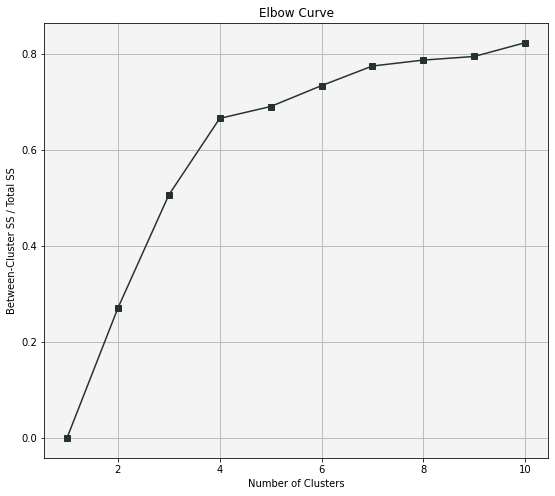

In [26]:
%matplotlib inline
from verticapy.learn.plot import elbow
predictors = ['Word_Cup_Victory',  
              'nb_Continental_Cup',
              'Number_Games_World_Tournament',    
              'Number_Games_Continental_Tournament',   
              'Percent_Victory_World_Tournament',
              'Percent_Victory_Continental_Tournament',  
              'Percent_Victory_Home',
              'Percent_Victory_Away']
elbow = elbow(predictors, 
              'football_clustering',
              n_cluster = (1, 11))

6 seems to be a suitable number of clusters. To help the algorithm to converge to meaningful clusters, we can initialize the clusters with different types of centroids levels. We can for example associate very good teams (champions) to World Cups Winners, good teams to continental Cups Winners... Besides, a team which had won a lot of games in a location where the level is not very good can not be considered as a good team if it didn't played World Tournaments.

In [27]:
from verticapy.learn.cluster import KMeans
        # w_cup c_cup w_games c_games w_vict c_vict h_vict a_vict
init =  [(0,    0,       0,  0.05,      0,    0,      0, 0.05), # very bad
         (0,    0,       0,  0.30,      0, 0.25,   0.30, 0.10), # bad
         (0,    0,    0.05,  0.40,   0.15, 0.35,   0.40, 0.20), # outsiders
         (0, 0.10,    0.15,  0.50,   0.20, 0.45,   0.50, 0.30), # good
         (0, 0.20,    0.30,  0.40,   0.40, 0.55,   0.60, 0.40), # strong
         (1,  0.5,       1,  0.80,   0.70, 0.65,   0.75, 0.55)] # champions  

drop_model("fifa_clusters")
model_kmeans = KMeans("fifa_clusters", 
                      n_cluster = 6,
                      init = init)
model_kmeans.fit("football_clustering", predictors)
model_kmeans.cluster_centers

The model fifa_clusters was successfully dropped.


,word_cup_victory,nb_continental_cup,number_games_world_tournament,number_games_continental_tournament,percent_victory_world_tournament,percent_victory_continental_tournament,percent_victory_home,percent_victory_away
0,0.0,0.0,0.0,0.0356587640886126,0.0,0.0376666283053255,0.0775017129231248,0.173344405066906
1,0.0,0.0,0.0,0.0202762268586542,0.0,0.0391480712563549,0.593941062388084,0.260025467557148
2,0.0,0.00416666666666667,0.00129764801297648,0.147690763052209,0.00185185185185185,0.272734457887144,0.450153680750178,0.256408127045046
3,0.0,0.0361842105263158,0.050710718401844,0.375554850982879,0.113992166132427,0.404622508244648,0.507846828538841,0.318140092013545
4,0.0,0.159090909090909,0.208803362088034,0.516246805403432,0.342376891632991,0.497092605940407,0.55005649660918,0.356151404084586
5,1.0,0.515625,0.635036496350365,0.610316265060241,0.529212056011815,0.587107049106601,0.61893194865411,0.434673942286204


<object>

We can add the prediction in the vDataFrame.

In [28]:
model_kmeans.predict(teams_kpi, 
                     name = "fifa_rank")

,confederation,Percent_Victory_Home,Avg_goals_conceded,Word_Cup_Victory,team1,Number_Games_Continental_Tournament,nb_Continental_Cup,nb_World_Cup,Avg_goals,Percent_Draw,Number_Games_World_Tournament,Percent_Victory_World_Tournament,Percent_Victory_Away,Percent_Victory_Continental_Tournament,Percent_Victory,fifa_rank
0,OFC,0.0,1.5,0,Abkhazia,0.0,0.0,0,1.0,0.5,0.0,0.0,0.166666666666667,0.0,0.166666666666667,0
1,AFC,0.4,2.05681818181818,0,Afghanistan,0.036144578313253,0.0,0,1.07954545454545,0.204545454545455,0.0,0.0,0.295774647887324,0.166666666666667,0.284090909090909,2
2,UEFA,0.404255319148936,1.5958904109589,0,Albania,0.283132530120482,0.0,0,0.900684931506849,0.222602739726027,0.0,0.0,0.173076923076923,0.148936170212766,0.23972602739726,2
3,OFC,0.0,4.33333333333333,0,Alderney,0.0,0.0,0,0.583333333333333,0.0,0.0,0.0,0.0833333333333333,0.0,0.0833333333333333,0
4,CAF,0.580645161290323,1.0304347826087,0,Algeria,0.439759036144578,0.125,0,1.35434782608696,0.280434782608696,0.094890510948905,0.230769230769231,0.31638418079096,0.410958904109589,0.415217391304348,3
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


<object>  Name: football_clustering, Number of rows: 272, Number of columns: 16

Let's look at the Champion Group. We can see well known teams like Argentina, Brazil or France.

In [29]:
teams_kpi.search(conditions = ["fifa_rank = 5"],
                 usecols = ["team1", "fifa_rank"],
                 order_by = ["fifa_rank"]).head(10)

,team1,fifa_rank
0,Uruguay,5
1,Spain,5
2,Italy,5
3,Germany,5
4,France,5
5,England,5
6,Brazil,5
7,Argentina,5


<object>  Name: search, Number of rows: 8, Number of columns: 2

The worst group includes teams that you may probably don't know like Aruba, American Samoa or Andorra...

In [30]:
teams_kpi.search(conditions = ["fifa_rank = 0"],
                 usecols = ["team1", "fifa_rank"],
                 order_by = ["fifa_rank"]).head(10)

,team1,fifa_rank
0,Zanzibar,0
1,Ynys Môn,0
2,Western Isles,0
3,Western Australia,0
4,Wallis Islands and Futuna,0
5,U.S. Virgin Islands,0
6,Tuvalu,0
7,Turks and Caicos Islands,0
8,Tonga,0
9,Tibet,0


<object>  Name: search, Number of rows: 62, Number of columns: 2

A Bubble Plot can show the level differences. We can clearly the champions group at the top right of the graphic whereas worst teams are at the bottom left. Some teams may be very good in their location but very bad in World Tournaments. They are mainly at the bottom right of the graph.

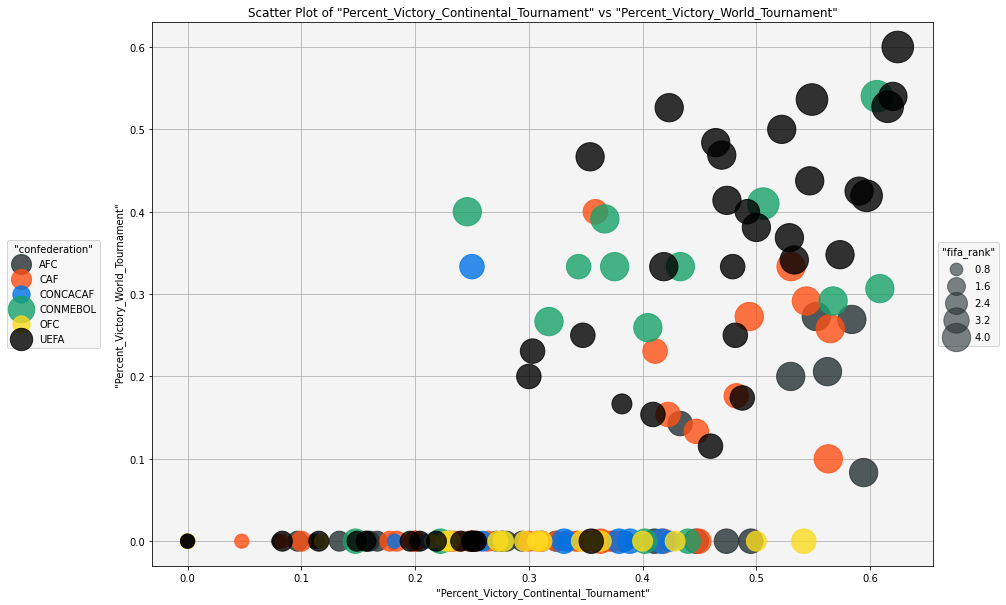

In [31]:
x = teams_kpi.bubble(["Percent_Victory_Continental_Tournament", 
                      "Percent_Victory_World_Tournament"],
                     size_bubble_col = "fifa_rank",
                     catcol = "confederation")

We can also look at the Percent of Victory by rank to ensure our hypothesis.

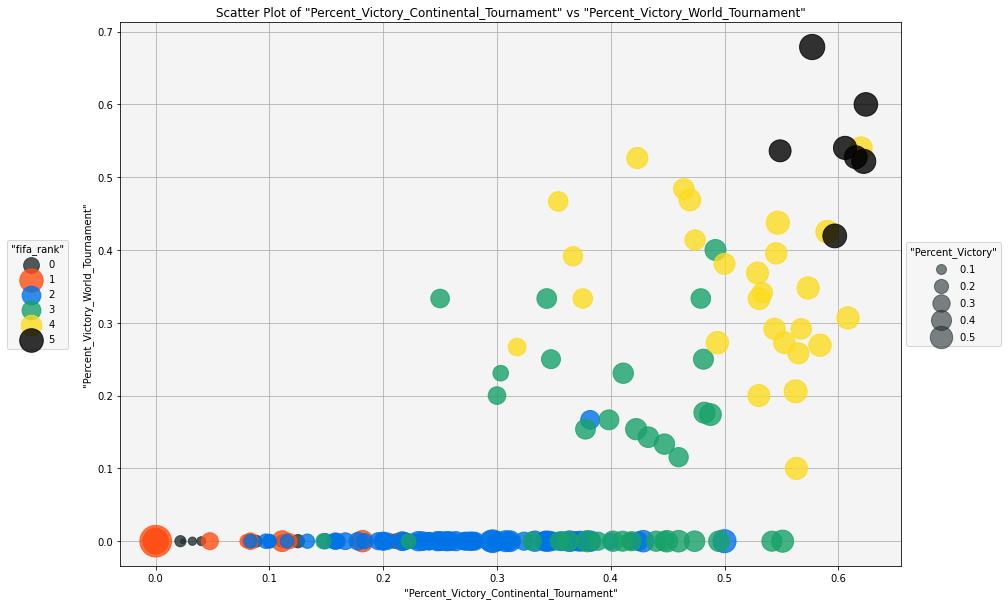

In [32]:
x = teams_kpi.bubble(["Percent_Victory_Continental_Tournament", 
                      "Percent_Victory_World_Tournament"],
                     size_bubble_col = "Percent_Victory",
                     catcol = "fifa_rank")

A box plot can also show us the teams skills differences. We can look at the rank 1 where the percent of victory is high because of the confederation. The best team of a championship where the teams are all not very good could possibly have a high Percent Victory in the location.

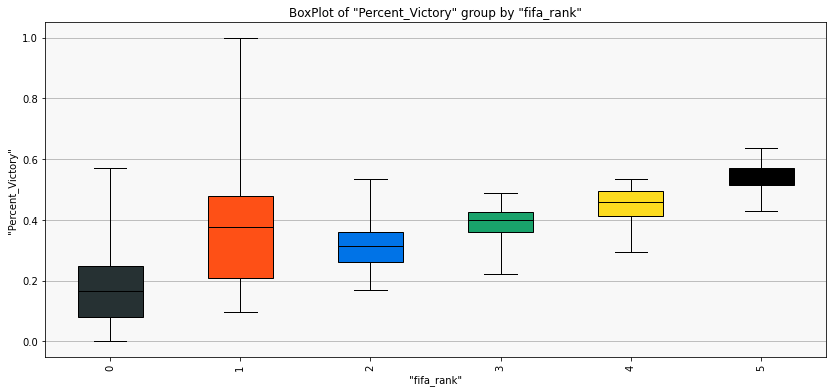

In [33]:
x = teams_kpi["Percent_Victory"].boxplot(by = "fifa_rank")

Let's export the different KPIs to the Vertica DataBase.

In [34]:
drop_table("team_kpi")
teams_kpi.to_db(name = "team_kpi",
                relation_type = "table",
                inplace = True)

The table team_kpi was successfully dropped.


,nb_World_Cup,fifa_rank,Avg_goals,Percent_Draw,Number_Games_World_Tournament,Percent_Victory_World_Tournament,Percent_Victory_Away,Percent_Victory_Continental_Tournament,confederation,Percent_Victory_Home,Avg_goals_conceded,Word_Cup_Victory,team1,Number_Games_Continental_Tournament,nb_Continental_Cup,Percent_Victory
0,0,0,1.0,0.5,0.0,0.0,0.166666666666667,0.0,OFC,0.0,1.5,0,Abkhazia,0.0,0.0,0.166666666666667
1,0,2,1.07954545454545,0.204545454545455,0.0,0.0,0.295774647887324,0.166666666666667,AFC,0.4,2.05681818181818,0,Afghanistan,0.036144578313253,0.0,0.284090909090909
2,0,2,0.900684931506849,0.222602739726027,0.0,0.0,0.173076923076923,0.148936170212766,UEFA,0.404255319148936,1.5958904109589,0,Albania,0.283132530120482,0.0,0.23972602739726
3,0,0,0.583333333333333,0.0,0.0,0.0,0.0833333333333333,0.0,OFC,0.0,4.33333333333333,0,Alderney,0.0,0.0,0.0833333333333333
4,0,3,1.35434782608696,0.280434782608696,0.094890510948905,0.230769230769231,0.31638418079096,0.410958904109589,CAF,0.580645161290323,1.0304347826087,0,Algeria,0.439759036144578,0.125,0.415217391304348
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


<object>  Name: team_kpi, Number of rows: 272, Number of columns: 16

## Features Engineering

Many very interesting features can be used to evaluate the teama shape. Moving windows of the previous games can give incredible information to the model. As the team can play away and at home (the two teams can also play at a neutral stadium), we will use the previous idea and intervert the away and home teams. By using this technique, we will never get twice the same game and we will get the exact moving windows we need.

In [35]:
from verticapy import *

football = vDataFrame("football_clean")
football["home_team"].rename("team1")
football["home_score"].rename("team1_score")
football["away_team"].rename("team2")
football["away_score"].rename("team2_score")
# will be used to filter the data after the features engineering
football.eval(name = "match_sample", expr = "1") 

football2 = vDataFrame("football_clean")
football2["home_team"].rename("team2")
football2["home_score"].rename("team2_score")
football2["away_team"].rename("team1")
football2["away_score"].rename("team1_score")
# will be used to filter the data after the features engineering
football2.eval(name = "match_sample", expr = "2")

# Merging the 2 interverted datasets
all_matchs = football.append(football2)

Let's add the different KPIs to our dataset.

In [36]:
all_matchs = all_matchs.join(teams_kpi,
                             on = {"team1": "team1"},
                             how = "left",
                             expr2 = ["nb_World_Cup AS nb_World_Cup_1",
                                      "fifa_rank AS fifa_rank_1",
                                      "Avg_goals AS Avg_goals_1",
                                      "Percent_Draw AS Percent_Draw_1",
                                      "Number_Games_World_Tournament AS Number_Games_World_Tournament_1",
                                      "Percent_Victory_World_Tournament AS Percent_Victory_World_Tournament_1",
                                      "Percent_Victory_Away AS Percent_Victory_Away_1",
                                      "Percent_Victory_Continental_Tournament AS Percent_Victory_Continental_Tournament_1",
                                      "confederation AS confederation_1",
                                      "Percent_Victory_Home AS Percent_Victory_Home_1",
                                      "Avg_goals_conceded AS Avg_goals_conceded_1",
                                      "Number_Games_Continental_Tournament AS Number_Games_Continental_Tournament_1",
                                      "nb_Continental_Cup AS nb_Continental_Cup_1",
                                      "Percent_Victory AS Percent_Victory_1"])
all_matchs = all_matchs.join(teams_kpi,
                             on = {"team2": "team1"},
                             how = "left",
                             expr2 = ["nb_World_Cup AS nb_World_Cup_2",
                                      "fifa_rank AS fifa_rank_2",
                                      "Avg_goals AS Avg_goals_2",
                                      "Percent_Draw AS Percent_Draw_2",
                                      "Number_Games_World_Tournament AS Number_Games_World_Tournament_2",
                                      "Percent_Victory_World_Tournament AS Percent_Victory_World_Tournament_2",
                                      "Percent_Victory_Away AS Percent_Victory_Away_2",
                                      "Percent_Victory_Continental_Tournament AS Percent_Victory_Continental_Tournament_2",
                                      "confederation AS confederation_2",
                                      "Percent_Victory_Home AS Percent_Victory_Home_2",
                                      "Avg_goals_conceded AS Avg_goals_conceded_2",
                                      "Number_Games_Continental_Tournament AS Number_Games_Continental_Tournament_2",
                                      "nb_Continental_Cup AS nb_Continental_Cup_2",
                                      "Percent_Victory AS Percent_Victory_2"])

We can add dumies to do aggregations on the different games.

In [37]:
all_matchs.eval(name = "victory_team1",
                expr = "(team1_score > team2_score)::int")
all_matchs.eval(name = "draw",
                expr = "(team1_score = team2_score)::int")
all_matchs.eval(name = "victory_team2",
                expr = "(team1_score < team2_score)::int")

,tournament,neutral,country,city,date,team1,team1_score,team2,team2_score,match_sample,nb_World_Cup_1,fifa_rank_1,Avg_goals_1,Percent_Draw_1,Number_Games_World_Tournament_1,Percent_Victory_World_Tournament_1,Percent_Victory_Away_1,Percent_Victory_Continental_Tournament_1,confederation_1,Percent_Victory_Home_1,Avg_goals_conceded_1,Number_Games_Continental_Tournament_1,nb_Continental_Cup_1,Percent_Victory_1,nb_World_Cup_2,fifa_rank_2,Avg_goals_2,Percent_Draw_2,Number_Games_World_Tournament_2,Percent_Victory_World_Tournament_2,Percent_Victory_Away_2,Percent_Victory_Continental_Tournament_2,confederation_2,Percent_Victory_Home_2,Avg_goals_conceded_2,Number_Games_Continental_Tournament_2,nb_Continental_Cup_2,Percent_Victory_2,victory_team1,draw,victory_team2
0,Friendly,False,Scotland,Glasgow,1872-11-30,Scotland,0,England,0,1,0,3,1.7503355704698,0.21744966442953,0.167883211678832,0.173913043478261,0.394230769230769,0.487603305785124,UEFA,0.58477508650519,1.2255033557047,0.364457831325301,0.0,0.476510067114094,1,5,2.19937369519833,0.241127348643006,0.452554744525547,0.419354838709677,0.530864197530864,0.596899224806202,UEFA,0.61878453038674,0.992693110647182,0.38855421686747,0.0,0.565762004175365,0,1,0
1,Friendly,False,England,London,1873-03-08,England,4,Scotland,2,1,1,5,2.19937369519833,0.241127348643006,0.452554744525547,0.419354838709677,0.530864197530864,0.596899224806202,UEFA,0.61878453038674,0.992693110647182,0.38855421686747,0.0,0.565762004175365,0,3,1.7503355704698,0.21744966442953,0.167883211678832,0.173913043478261,0.394230769230769,0.487603305785124,UEFA,0.58477508650519,1.2255033557047,0.364457831325301,0.0,0.476510067114094,1,0,0
2,Friendly,False,Scotland,Glasgow,1874-03-07,Scotland,2,England,1,1,0,3,1.7503355704698,0.21744966442953,0.167883211678832,0.173913043478261,0.394230769230769,0.487603305785124,UEFA,0.58477508650519,1.2255033557047,0.364457831325301,0.0,0.476510067114094,1,5,2.19937369519833,0.241127348643006,0.452554744525547,0.419354838709677,0.530864197530864,0.596899224806202,UEFA,0.61878453038674,0.992693110647182,0.38855421686747,0.0,0.565762004175365,1,0,0
3,Friendly,False,England,London,1875-03-06,England,2,Scotland,2,1,1,5,2.19937369519833,0.241127348643006,0.452554744525547,0.419354838709677,0.530864197530864,0.596899224806202,UEFA,0.61878453038674,0.992693110647182,0.38855421686747,0.0,0.565762004175365,0,3,1.7503355704698,0.21744966442953,0.167883211678832,0.173913043478261,0.394230769230769,0.487603305785124,UEFA,0.58477508650519,1.2255033557047,0.364457831325301,0.0,0.476510067114094,0,1,0
4,Friendly,False,Scotland,Glasgow,1876-03-04,Scotland,3,England,0,1,0,3,1.7503355704698,0.21744966442953,0.167883211678832,0.173913043478261,0.394230769230769,0.487603305785124,UEFA,0.58477508650519,1.2255033557047,0.364457831325301,0.0,0.476510067114094,1,5,2.19937369519833,0.241127348643006,0.452554744525547,0.419354838709677,0.530864197530864,0.596899224806202,UEFA,0.61878453038674,0.992693110647182,0.38855421686747,0.0,0.565762004175365,1,0,0
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


<object>  Name: join, Number of rows: 82818, Number of columns: 41

Let's use moving windows to compute many interesting features.

<b>The teams shapes (percentage of victories and draws in the last games)</b>

In [38]:
# TEAM 1

# Victory 10 previous games
all_matchs.rolling(func = "avg",
                   column = "victory_team1",
                   preceding = 10,
                   following = 1,
                   name = "avg_victory_team1_1_10",
                   by = ["team1"],
                   order_by = ["date"],
                   method = "rows",
                   rule = "past")
# Victory 3 previous games
all_matchs.rolling(func = "avg",
                   column = "victory_team1",
                   preceding = 3,
                   following = 1,
                   name = "avg_victory_team1_1_3",
                   by = ["team1"],
                   order_by = ["date"],
                   method = "rows",
                   rule = "past")
# Draw 5 previous games
all_matchs.rolling(func = "avg",
                   column = "draw",
                   preceding = 5,
                   following = 1,
                   name = "avg_draw_team1_1_5",
                   by = ["team1"],
                   order_by = ["date"],
                   method = "rows",
                   rule = "past")

# TEAM 2

# Victory 10 previous games
all_matchs.rolling(func = "avg",
                   column = "victory_team2",
                   preceding = 10,
                   following = 1,
                   name = "avg_victory_team2_1_10",
                   by = ["team2"],
                   order_by = ["date"],
                   method = "rows",
                   rule = "past")
# Victory 3 previous games
all_matchs.rolling(func = "avg",
                   column = "victory_team2",
                   preceding = 3,
                   following = 1,
                   name = "avg_victory_team2_1_3",
                   by = ["team2"],
                   order_by = ["date"],
                   method = "rows",
                   rule = "past")
# Draw 5 previous games
all_matchs.rolling(func = "avg",
                   column = "draw",
                   preceding = 5,
                   following = 1,
                   name = "avg_draw_team2_1_5",
                   by = ["team2"],
                   order_by = ["date"],
                   method = "rows",
                   rule = "past")

,tournament,neutral,country,city,date,team1,team1_score,team2,team2_score,match_sample,nb_World_Cup_1,fifa_rank_1,Avg_goals_1,Percent_Draw_1,Number_Games_World_Tournament_1,Percent_Victory_World_Tournament_1,Percent_Victory_Away_1,Percent_Victory_Continental_Tournament_1,confederation_1,Percent_Victory_Home_1,Avg_goals_conceded_1,Number_Games_Continental_Tournament_1,nb_Continental_Cup_1,Percent_Victory_1,nb_World_Cup_2,fifa_rank_2,Avg_goals_2,Percent_Draw_2,Number_Games_World_Tournament_2,Percent_Victory_World_Tournament_2,Percent_Victory_Away_2,Percent_Victory_Continental_Tournament_2,confederation_2,Percent_Victory_Home_2,Avg_goals_conceded_2,Number_Games_Continental_Tournament_2,nb_Continental_Cup_2,Percent_Victory_2,victory_team1,draw,victory_team2,avg_victory_team1_1_10,avg_victory_team1_1_3,avg_draw_team1_1_5,avg_victory_team2_1_10,avg_victory_team2_1_3,avg_draw_team2_1_5
0,Friendly,False,Azerbaijan,Stepanakert,2012-10-21,Artsakh,3,Abkhazia,0,1,0,1,3.0,0.0,0.0,0.0,0.0,0.0,OFC,1.0,0.0,0.0,0.0,1.0,0,0,1.0,0.5,0.0,0.0,0.166666666666667,0.0,OFC,0.0,1.5,0.0,0.0,0.166666666666667,1,0,0,None,None,None,None,None,None
1,CONIFA World Football Cup,True,Sweden,Östersund,2014-06-01,Occitania,1,Abkhazia,1,2,0,0,1.25,0.166666666666667,0.0,0.0,0.3,0.0,OFC,0.0,1.83333333333333,0.0,0.0,0.25,0,0,1.0,0.5,0.0,0.0,0.166666666666667,0.0,OFC,0.0,1.5,0.0,0.0,0.166666666666667,0,1,0,0.125,0.333333333333333,0.0,0.0,0.0,0.0
2,CONIFA World Football Cup,False,Sweden,Östersund,2014-06-02,Sápmi,1,Abkhazia,2,1,0,1,4.35714285714286,0.142857142857143,0.0,0.0,0.5,0.0,OFC,0.375,1.71428571428571,0.0,0.0,0.428571428571429,0,0,1.0,0.5,0.0,0.0,0.166666666666667,0.0,OFC,0.0,1.5,0.0,0.0,0.166666666666667,0,0,1,0.4,0.0,0.2,0.0,0.0,0.5
3,CONIFA World Football Cup,True,Sweden,Östersund,2014-06-04,South Ossetia,0,Abkhazia,0,2,0,0,0.666666666666667,0.333333333333333,0.0,0.0,0.0,0.0,OFC,0.0,2.33333333333333,0.0,0.0,0.0,0,0,1.0,0.5,0.0,0.0,0.166666666666667,0.0,OFC,0.0,1.5,0.0,0.0,0.166666666666667,0,1,0,0.0,0.0,0.0,0.333333333333333,0.333333333333333,0.333333333333333
4,CONIFA World Football Cup,True,Sweden,Östersund,2014-06-05,Padania,3,Abkhazia,3,1,0,1,2.5,0.125,0.0,0.0,0.833333333333333,0.0,OFC,1.0,0.5625,0.0,0.0,0.875,0,0,1.0,0.5,0.0,0.0,0.166666666666667,0.0,OFC,0.0,1.5,0.0,0.0,0.166666666666667,0,1,0,1.0,1.0,0.0,0.25,0.333333333333333,0.5
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


<object>  Name: join, Number of rows: 82818, Number of columns: 47

<b>The teams shapes in the last same tournament</b>

In [39]:
# TEAM 1

# Victory 10 previous games
all_matchs.rolling(func = "avg",
                   column = "victory_team1",
                   preceding = 10,
                   following = 1,
                   name = "avg_victory_same_tournament_team1_1_10",
                   by = ["team1", "tournament"],
                   order_by = ["date"],
                   method = "rows",
                   rule = "past")
# Victory 3 previous games
all_matchs.rolling(func = "avg",
                   column = "victory_team1",
                   preceding = 3,
                   following = 1,
                   name = "avg_victory_same_tournament_team1_1_3",
                   by = ["team1", "tournament"],
                   order_by = ["date"],
                   method = "rows",
                   rule = "past")
# Draw 5 previous games
all_matchs.rolling(func = "avg",
                   column = "draw",
                   preceding = 5,
                   following = 1,
                   name = "avg_draw_same_tournament_team1_1_5",
                   by = ["team1", "tournament"],
                   order_by = ["date"],
                   method = "rows",
                   rule = "past")

# TEAM 2

# Victory 10 previous games
all_matchs.rolling(func = "avg",
                   column = "victory_team2",
                   preceding = 10,
                   following = 1,
                   name = "avg_victory_same_tournament_team2_1_10",
                   by = ["team2", "tournament"],
                   order_by = ["date"],
                   method = "rows",
                   rule = "past")
# Victory 3 previous games
all_matchs.rolling(func = "avg",
                   column = "victory_team2",
                   preceding = 3,
                   following = 1,
                   name = "avg_victory_same_tournament_team2_1_3",
                   by = ["team2", "tournament"],
                   order_by = ["date"],
                   method = "rows",
                   rule = "past")
# Draw 5 previous games
all_matchs.rolling(func = "avg",
                   column = "draw",
                   preceding = 5,
                   following = 1,
                   name = "avg_draw_same_tournament_team2_1_5",
                   by = ["team2", "tournament"],
                   order_by = ["date"],
                   method = "rows",
                   rule = "past")

,tournament,neutral,country,city,date,team1,team1_score,team2,team2_score,match_sample,nb_World_Cup_1,fifa_rank_1,Avg_goals_1,Percent_Draw_1,Number_Games_World_Tournament_1,Percent_Victory_World_Tournament_1,Percent_Victory_Away_1,Percent_Victory_Continental_Tournament_1,confederation_1,Percent_Victory_Home_1,Avg_goals_conceded_1,Number_Games_Continental_Tournament_1,nb_Continental_Cup_1,Percent_Victory_1,nb_World_Cup_2,fifa_rank_2,Avg_goals_2,Percent_Draw_2,Number_Games_World_Tournament_2,Percent_Victory_World_Tournament_2,Percent_Victory_Away_2,Percent_Victory_Continental_Tournament_2,confederation_2,Percent_Victory_Home_2,Avg_goals_conceded_2,Number_Games_Continental_Tournament_2,nb_Continental_Cup_2,Percent_Victory_2,victory_team1,draw,victory_team2,avg_victory_team1_1_10,avg_victory_team1_1_3,avg_draw_team1_1_5,avg_victory_team2_1_10,avg_victory_team2_1_3,avg_draw_team2_1_5,avg_victory_same_tournament_team1_1_10,avg_victory_same_tournament_team1_1_3,avg_draw_same_tournament_team1_1_5,avg_victory_same_tournament_team2_1_10,avg_victory_same_tournament_team2_1_3,avg_draw_same_tournament_team2_1_5
0,ABCS Tournament,False,Curaçao,Willemstad,2010-10-29,Curaçao,3,Aruba,0,1,0,2,1.54785478547855,0.267326732673267,0.0,0.0,0.294444444444444,0.216666666666667,CONCACAF,0.666666666666667,1.67656765676568,0.180722891566265,0.0,0.356435643564356,0,2,1.32407407407407,0.240740740740741,0.0,0.0,0.0847457627118644,0.230769230769231,OFC,0.333333333333333,2.40740740740741,0.039156626506024,0.0,0.185185185185185,1,0,0,0.1,0.0,0.4,0.0,0.0,0.2,None,None,None,None,None,None
1,ABCS Tournament,True,Curaçao,Willemstad,2010-10-31,Bonaire,3,Aruba,3,2,0,0,1.61538461538462,0.153846153846154,0.0,0.0,0.307692307692308,0.0,OFC,0.0,3.38461538461538,0.0,0.0,0.307692307692308,0,2,1.32407407407407,0.240740740740741,0.0,0.0,0.0847457627118644,0.230769230769231,OFC,0.333333333333333,2.40740740740741,0.039156626506024,0.0,0.185185185185185,0,1,0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0
2,ABCS Tournament,False,Suriname,Paramaribo,2011-12-02,Suriname,0,Aruba,0,1,0,2,1.93313069908815,0.237082066869301,0.0,0.0,0.351851851851852,0.311475409836066,OFC,0.632075471698113,1.45288753799392,0.183734939759036,0.0,0.434650455927052,0,2,1.32407407407407,0.240740740740741,0.0,0.0,0.0847457627118644,0.230769230769231,OFC,0.333333333333333,2.40740740740741,0.039156626506024,0.0,0.185185185185185,0,1,0,0.4,0.0,0.2,0.1,0.333333333333333,0.2,0.5,0.5,0.5,0.0,0.0,0.5
3,ABCS Tournament,True,Suriname,Paramaribo,2011-12-04,Bonaire,2,Aruba,2,1,0,0,1.61538461538462,0.153846153846154,0.0,0.0,0.307692307692308,0.0,OFC,0.0,3.38461538461538,0.0,0.0,0.307692307692308,0,2,1.32407407407407,0.240740740740741,0.0,0.0,0.0847457627118644,0.230769230769231,OFC,0.333333333333333,2.40740740740741,0.039156626506024,0.0,0.185185185185185,0,1,0,0.333333333333333,0.333333333333333,0.333333333333333,0.1,0.333333333333333,0.4,0.333333333333333,0.333333333333333,0.333333333333333,0.0,0.0,0.666666666666667
4,ABCS Tournament,False,Aruba,Oranjestad,2012-07-13,Curaçao,2,Aruba,3,2,0,2,1.54785478547855,0.267326732673267,0.0,0.0,0.294444444444444,0.216666666666667,CONCACAF,0.666666666666667,1.67656765676568,0.180722891566265,0.0,0.356435643564356,0,2,1.32407407407407,0.240740740740741,0.0,0.0,0.0847457627118644,0.230769230769231,OFC,0.333333333333333,2.40740740740741,0.039156626506024,0.0,0.185185185185185,0,0,1,0.2,0.333333333333333,0.2,0.1,0.0,0.6,0.25,0.0,0.25,0.0,0.0,0.75
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


<object>  Name: join, Number of rows: 82818, Number of columns: 53

<b>Direct Confrontation</b>

In [40]:
# Victory 5 previous games
all_matchs.rolling(func = "avg",
                   column = "victory_team1",
                   preceding = 5,
                   following = 1,
                   name = "avg_victory_direct_team1_1_5",
                   by = ["team1", "team2"],
                   order_by = ["date"],
                   method = "rows",
                   rule = "past")
# Victory 3 previous games
all_matchs.rolling(func = "avg",
                   column = "victory_team1",
                   preceding = 3,
                   following = 1,
                   name = "avg_victory_direct_team1_1_3",
                   by = ["team1", "team2"],
                   order_by = ["date"],
                   method = "rows",
                   rule = "past")
# Draw 5 previous games
all_matchs.rolling(func = "avg",
                   column = "draw",
                   preceding = 5,
                   following = 1,
                   name = "avg_draw_direct_team1_1_5",
                   by = ["team1", "team2"],
                   order_by = ["date"],
                   method = "rows",
                   rule = "past")

,tournament,neutral,country,city,date,team1,team1_score,team2,team2_score,match_sample,nb_World_Cup_1,fifa_rank_1,Avg_goals_1,Percent_Draw_1,Number_Games_World_Tournament_1,Percent_Victory_World_Tournament_1,Percent_Victory_Away_1,Percent_Victory_Continental_Tournament_1,confederation_1,Percent_Victory_Home_1,Avg_goals_conceded_1,Number_Games_Continental_Tournament_1,nb_Continental_Cup_1,Percent_Victory_1,nb_World_Cup_2,fifa_rank_2,Avg_goals_2,Percent_Draw_2,Number_Games_World_Tournament_2,Percent_Victory_World_Tournament_2,Percent_Victory_Away_2,Percent_Victory_Continental_Tournament_2,confederation_2,Percent_Victory_Home_2,Avg_goals_conceded_2,Number_Games_Continental_Tournament_2,nb_Continental_Cup_2,Percent_Victory_2,victory_team1,draw,victory_team2,avg_victory_team1_1_10,avg_victory_team1_1_3,avg_draw_team1_1_5,avg_victory_team2_1_10,avg_victory_team2_1_3,avg_draw_team2_1_5,avg_victory_same_tournament_team1_1_10,avg_victory_same_tournament_team1_1_3,avg_draw_same_tournament_team1_1_5,avg_victory_same_tournament_team2_1_10,avg_victory_same_tournament_team2_1_3,avg_draw_same_tournament_team2_1_5,avg_victory_direct_team1_1_5,avg_victory_direct_team1_1_3,avg_draw_direct_team1_1_5
0,ABCS Tournament,False,Curaçao,Willemstad,2010-10-29,Curaçao,3,Aruba,0,1,0,2,1.54785478547855,0.267326732673267,0.0,0.0,0.294444444444444,0.216666666666667,CONCACAF,0.666666666666667,1.67656765676568,0.180722891566265,0.0,0.356435643564356,0,2,1.32407407407407,0.240740740740741,0.0,0.0,0.0847457627118644,0.230769230769231,OFC,0.333333333333333,2.40740740740741,0.039156626506024,0.0,0.185185185185185,1,0,0,0.1,0.0,0.4,0.0,0.0,0.2,None,None,None,None,None,None,0.6,0.666666666666667,0.2
1,ABCS Tournament,True,Curaçao,Willemstad,2010-10-31,Bonaire,3,Aruba,3,2,0,0,1.61538461538462,0.153846153846154,0.0,0.0,0.307692307692308,0.0,OFC,0.0,3.38461538461538,0.0,0.0,0.307692307692308,0,2,1.32407407407407,0.240740740740741,0.0,0.0,0.0847457627118644,0.230769230769231,OFC,0.333333333333333,2.40740740740741,0.039156626506024,0.0,0.185185185185185,0,1,0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,None,None,None
2,ABCS Tournament,False,Suriname,Paramaribo,2011-12-02,Suriname,0,Aruba,0,1,0,2,1.93313069908815,0.237082066869301,0.0,0.0,0.351851851851852,0.311475409836066,OFC,0.632075471698113,1.45288753799392,0.183734939759036,0.0,0.434650455927052,0,2,1.32407407407407,0.240740740740741,0.0,0.0,0.0847457627118644,0.230769230769231,OFC,0.333333333333333,2.40740740740741,0.039156626506024,0.0,0.185185185185185,0,1,0,0.4,0.0,0.2,0.1,0.333333333333333,0.2,0.5,0.5,0.5,0.0,0.0,0.5,1.0,1.0,0.0
3,ABCS Tournament,True,Suriname,Paramaribo,2011-12-04,Bonaire,2,Aruba,2,1,0,0,1.61538461538462,0.153846153846154,0.0,0.0,0.307692307692308,0.0,OFC,0.0,3.38461538461538,0.0,0.0,0.307692307692308,0,2,1.32407407407407,0.240740740740741,0.0,0.0,0.0847457627118644,0.230769230769231,OFC,0.333333333333333,2.40740740740741,0.039156626506024,0.0,0.185185185185185,0,1,0,0.333333333333333,0.333333333333333,0.333333333333333,0.1,0.333333333333333,0.4,0.333333333333333,0.333333333333333,0.333333333333333,0.0,0.0,0.666666666666667,0.0,0.0,1.0
4,ABCS Tournament,False,Aruba,Oranjestad,2012-07-13,Curaçao,2,Aruba,3,2,0,2,1.54785478547855,0.267326732673267,0.0,0.0,0.294444444444444,0.216666666666667,CONCACAF,0.666666666666667,1.67656765676568,0.180722891566265,0.0,0.356435643564356,0,2,1.32407407407407,0.240740740740741,0.0,0.0,0.0847457627118644,0.230769230769231,OFC,0.333333333333333,2.40740740740741,0.039156626506024,0.0,0.185185185185185,0,0,1,0.2,0.333333333333333,0.2,0.1,0.0,0.6,0.25,0.0,0.25,0.0,0.0,0.75,0.6,0.666666666666667,0.2
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


<object>  Name: join, Number of rows: 82818, Number of columns: 56

<b>Games against an opponents having the same rank</b>

In [41]:
# TEAM 1

# Victory 5 previous games
all_matchs.rolling(func = "avg",
                   column = "victory_team1",
                   preceding = 5,
                   following = 1,
                   name = "avg_victory_rank2_team1_1_5",
                   by = ["team1", "fifa_rank_2"],
                   order_by = ["date"],
                   method = "rows",
                   rule = "past")
# Draw 5 previous games
all_matchs.rolling(func = "avg",
                   column = "draw",
                   preceding = 5,
                   following = 1,
                   name = "avg_draw_rank2_team1_1_5",
                   by = ["team1", "fifa_rank_2"],
                   order_by = ["date"],
                   method = "rows",
                   rule = "past")

# TEAM 2

# Victory 5 previous games
all_matchs.rolling(func = "avg",
                   column = "victory_team2",
                   preceding = 5,
                   following = 1,
                   name = "avg_victory_rank1_team2_1_5",
                   by = ["team2", "fifa_rank_1"],
                   order_by = ["date"],
                   method = "rows",
                   rule = "past")
# Draw 5 previous games
all_matchs.rolling(func = "avg",
                   column = "draw",
                   preceding = 5,
                   following = 1,
                   name = "avg_draw_rank1_team2_1_5",
                   by = ["team2", "fifa_rank_1"],
                   order_by = ["date"],
                   method = "rows",
                   rule = "past")

,tournament,neutral,country,city,date,team1,team1_score,team2,team2_score,match_sample,nb_World_Cup_1,fifa_rank_1,Avg_goals_1,Percent_Draw_1,Number_Games_World_Tournament_1,Percent_Victory_World_Tournament_1,Percent_Victory_Away_1,Percent_Victory_Continental_Tournament_1,confederation_1,Percent_Victory_Home_1,Avg_goals_conceded_1,Number_Games_Continental_Tournament_1,nb_Continental_Cup_1,Percent_Victory_1,nb_World_Cup_2,fifa_rank_2,Avg_goals_2,Percent_Draw_2,Number_Games_World_Tournament_2,Percent_Victory_World_Tournament_2,Percent_Victory_Away_2,Percent_Victory_Continental_Tournament_2,confederation_2,Percent_Victory_Home_2,Avg_goals_conceded_2,Number_Games_Continental_Tournament_2,nb_Continental_Cup_2,Percent_Victory_2,victory_team1,draw,victory_team2,avg_victory_team1_1_10,avg_victory_team1_1_3,avg_draw_team1_1_5,avg_victory_team2_1_10,avg_victory_team2_1_3,avg_draw_team2_1_5,avg_victory_same_tournament_team1_1_10,avg_victory_same_tournament_team1_1_3,avg_draw_same_tournament_team1_1_5,avg_victory_same_tournament_team2_1_10,avg_victory_same_tournament_team2_1_3,avg_draw_same_tournament_team2_1_5,avg_victory_direct_team1_1_5,avg_victory_direct_team1_1_3,avg_draw_direct_team1_1_5,avg_victory_rank2_team1_1_5,avg_draw_rank2_team1_1_5,avg_victory_rank1_team2_1_5,avg_draw_rank1_team2_1_5
0,CONIFA World Football Cup,False,Georgia,Suhkumi,2016-05-29,Chagos Islands,0,Abkhazia,9,2,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0,0,1.0,0.5,0.0,0.0,0.166666666666667,0.0,OFC,0.0,1.5,0.0,0.0,0.166666666666667,0,0,1,None,None,None,0.166666666666667,0.0,0.6,None,None,None,0.2,0.0,0.6,None,None,None,None,None,None,None
1,CONIFA World Football Cup,False,Georgia,Suhkumi,2016-05-31,Western Armenia,0,Abkhazia,1,2,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0,0,1.0,0.5,0.0,0.0,0.166666666666667,0.0,OFC,0.0,1.5,0.0,0.0,0.166666666666667,0,0,1,None,None,None,0.285714285714286,0.333333333333333,0.4,None,None,None,0.333333333333333,0.333333333333333,0.4,None,None,None,None,None,1.0,0.0
2,CONIFA World Football Cup,False,Georgia,Suhkumi,2016-06-05,Panjab,1,Abkhazia,1,2,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0,0,1.0,0.5,0.0,0.0,0.166666666666667,0.0,OFC,0.0,1.5,0.0,0.0,0.166666666666667,0,1,0,0.5,0.5,0.0,0.5,1.0,0.0,0.5,0.5,0.0,0.555555555555556,1.0,0.0,None,None,None,None,None,1.0,0.0
3,CONIFA European Football Cup,True,Azerbaijan,Stepanakert,2019-06-06,Western Armenia,1,Abkhazia,1,2,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0,0,1.0,0.5,0.0,0.0,0.166666666666667,0.0,OFC,0.0,1.5,0.0,0.0,0.166666666666667,0,1,0,0.285714285714286,0.666666666666667,0.4,0.4,0.666666666666667,0.4,0.5,0.5,0.5,0.333333333333333,0.333333333333333,0.6,0.0,0.0,0.0,0.5,0.0,0.666666666666667,0.333333333333333
4,CONIFA World Football Cup,True,Sweden,Östersund,2014-06-01,Occitania,1,Abkhazia,1,2,0,0,1.25,0.166666666666667,0.0,0.0,0.3,0.0,OFC,0.0,1.83333333333333,0.0,0.0,0.25,0,0,1.0,0.5,0.0,0.0,0.166666666666667,0.0,OFC,0.0,1.5,0.0,0.0,0.166666666666667,0,1,0,0.125,0.333333333333333,0.0,0.0,0.0,0.0,None,None,None,None,None,None,None,None,None,0.5,0.0,None,None
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


<object>  Name: join, Number of rows: 82818, Number of columns: 60

<b>Games between teams having rank 1 and teams having rank 2</b>

In [42]:
# Victory 5 previous games
all_matchs.rolling(func = "avg",
                   column = "victory_team1",
                   preceding = 5,
                   following = 1,
                   name = "avg_victory_rank1_rank2_team1_1_5",
                   by = ["fifa_rank_1", "fifa_rank_2"],
                   order_by = ["date"],
                   method = "rows",
                   rule = "past")
# Draw 5 previous games
all_matchs.rolling(func = "avg",
                   column = "draw",
                   preceding = 5,
                   following = 1,
                   name = "avg_draw_rank1_rank2_team1_1_5",
                   by = ["fifa_rank_1", "fifa_rank_2"],
                   order_by = ["date"],
                   method = "rows",
                   rule = "past")

,tournament,neutral,country,city,date,team1,team1_score,team2,team2_score,match_sample,nb_World_Cup_1,fifa_rank_1,Avg_goals_1,Percent_Draw_1,Number_Games_World_Tournament_1,Percent_Victory_World_Tournament_1,Percent_Victory_Away_1,Percent_Victory_Continental_Tournament_1,confederation_1,Percent_Victory_Home_1,Avg_goals_conceded_1,Number_Games_Continental_Tournament_1,nb_Continental_Cup_1,Percent_Victory_1,nb_World_Cup_2,fifa_rank_2,Avg_goals_2,Percent_Draw_2,Number_Games_World_Tournament_2,Percent_Victory_World_Tournament_2,Percent_Victory_Away_2,Percent_Victory_Continental_Tournament_2,confederation_2,Percent_Victory_Home_2,Avg_goals_conceded_2,Number_Games_Continental_Tournament_2,nb_Continental_Cup_2,Percent_Victory_2,victory_team1,draw,victory_team2,avg_victory_team1_1_10,avg_victory_team1_1_3,avg_draw_team1_1_5,avg_victory_team2_1_10,avg_victory_team2_1_3,avg_draw_team2_1_5,avg_victory_same_tournament_team1_1_10,avg_victory_same_tournament_team1_1_3,avg_draw_same_tournament_team1_1_5,avg_victory_same_tournament_team2_1_10,avg_victory_same_tournament_team2_1_3,avg_draw_same_tournament_team2_1_5,avg_victory_direct_team1_1_5,avg_victory_direct_team1_1_3,avg_draw_direct_team1_1_5,avg_victory_rank2_team1_1_5,avg_draw_rank2_team1_1_5,avg_victory_rank1_team2_1_5,avg_draw_rank1_team2_1_5,avg_victory_rank1_rank2_team1_1_5,avg_draw_rank1_rank2_team1_1_5
0,World Unity Cup,False,England,London,2016-08-26,Chagos Islands,3,Barawa,2,2,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,None,None,None,0.0,0.0,0.0,None,None,None,None,None,None,None,None,None
1,World Unity Cup,False,England,London,2016-08-26,Barawa,2,Chagos Islands,3,1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,None,None,None,None,None,None,None,None,None,1.0,0.0
2,Friendly,False,England,London,2018-04-08,Chagos Islands,1,Barawa,4,2,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0,0,1,0.5,0.5,0.0,0.0,0.0,0.0,None,None,None,None,None,None,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.5,0.0
3,Friendly,False,England,London,2018-04-08,Barawa,4,Chagos Islands,1,1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,1,0,0,0.0,0.0,0.0,0.5,0.5,0.0,None,None,None,None,None,None,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.333333333333333,0.0
4,CONIFA World Football Cup,True,England,Carshalton,2018-05-31,Western Armenia,0,United Koreans in Japan,0,2,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0,1,0,0.0,0.0,0.333333333333333,0.2,0.0,0.4,0.0,0.0,0.333333333333333,0.2,0.0,0.4,None,None,None,None,None,None,None,0.5,0.0
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


<object>  Name: join, Number of rows: 82818, Number of columns: 62

In order to be used by our model, we need to convert the variable 'neutral' to integer.
We need also to create our response column which is the game issue.

In [43]:
all_matchs["neutral"].astype("int")
all_matchs.eval(name = "result",
                expr = "CASE WHEN team1_score > team2_score THEN '1' WHEN team1_score = team2_score THEN 'X' ELSE '2' END")

,tournament,neutral,country,city,date,team1,team1_score,team2,team2_score,match_sample,nb_World_Cup_1,fifa_rank_1,Avg_goals_1,Percent_Draw_1,Number_Games_World_Tournament_1,Percent_Victory_World_Tournament_1,Percent_Victory_Away_1,Percent_Victory_Continental_Tournament_1,confederation_1,Percent_Victory_Home_1,Avg_goals_conceded_1,Number_Games_Continental_Tournament_1,nb_Continental_Cup_1,Percent_Victory_1,nb_World_Cup_2,fifa_rank_2,Avg_goals_2,Percent_Draw_2,Number_Games_World_Tournament_2,Percent_Victory_World_Tournament_2,Percent_Victory_Away_2,Percent_Victory_Continental_Tournament_2,confederation_2,Percent_Victory_Home_2,Avg_goals_conceded_2,Number_Games_Continental_Tournament_2,nb_Continental_Cup_2,Percent_Victory_2,victory_team1,draw,victory_team2,avg_victory_team1_1_10,avg_victory_team1_1_3,avg_draw_team1_1_5,avg_victory_team2_1_10,avg_victory_team2_1_3,avg_draw_team2_1_5,avg_victory_same_tournament_team1_1_10,avg_victory_same_tournament_team1_1_3,avg_draw_same_tournament_team1_1_5,avg_victory_same_tournament_team2_1_10,avg_victory_same_tournament_team2_1_3,avg_draw_same_tournament_team2_1_5,avg_victory_direct_team1_1_5,avg_victory_direct_team1_1_3,avg_draw_direct_team1_1_5,avg_victory_rank2_team1_1_5,avg_draw_rank2_team1_1_5,avg_victory_rank1_team2_1_5,avg_draw_rank1_team2_1_5,avg_victory_rank1_rank2_team1_1_5,avg_draw_rank1_rank2_team1_1_5,result
0,World Unity Cup,0,England,London,2016-08-26,Chagos Islands,3,Barawa,2,2,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,None,None,None,0.0,0.0,0.0,None,None,None,None,None,None,None,None,None,1
1,World Unity Cup,0,England,London,2016-08-26,Barawa,2,Chagos Islands,3,1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,None,None,None,None,None,None,None,None,None,1.0,0.0,2
2,Friendly,0,England,London,2018-04-08,Chagos Islands,1,Barawa,4,2,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0,0,1,0.5,0.5,0.0,0.0,0.0,0.0,None,None,None,None,None,None,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.5,0.0,2
3,Friendly,0,England,London,2018-04-08,Barawa,4,Chagos Islands,1,1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,1,0,0,0.0,0.0,0.0,0.5,0.5,0.0,None,None,None,None,None,None,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.333333333333333,0.0,1
4,CONIFA World Football Cup,1,England,Carshalton,2018-05-31,Western Armenia,0,United Koreans in Japan,0,2,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0,1,0,0.0,0.0,0.333333333333333,0.2,0.0,0.4,0.0,0.0,0.333333333333333,0.2,0.0,0.4,None,None,None,None,None,None,None,0.5,0.0,X
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


<object>  Name: join, Number of rows: 82818, Number of columns: 63

Some missing values could be created because of many reasons:
<ul class="ul_param">
    <li>The two teams never played one against the other (no direct confrontation)</li>
    <li>One of the team played the competition for the first time</li>
    <li>...</li>
</ul>

In [44]:
all_matchs.count()

,count,percent
"""tournament""",82818.0,100.0
"""neutral""",82818.0,100.0
"""country""",82818.0,100.0
"""city""",82818.0,100.0
"""date""",82818.0,100.0
"""team1""",82818.0,100.0
"""team1_score""",82818.0,100.0
"""team2""",82818.0,100.0
"""team2_score""",82818.0,100.0
"""match_sample""",82818.0,100.0


<object>

We need to impute these missing values using different strategies.

In [45]:
all_matchs["avg_victory_direct_team1_1_5"].apply("COALESCE({}, avg_victory_rank2_team1_1_5, avg_victory_rank1_rank2_team1_1_5)")
all_matchs["avg_victory_direct_team1_1_3"].apply("COALESCE({}, avg_victory_rank2_team1_1_5, avg_victory_rank1_rank2_team1_1_5)")
all_matchs["avg_draw_direct_team1_1_5"].apply("COALESCE({}, avg_draw_rank2_team1_1_5, avg_draw_rank1_rank2_team1_1_5)")
all_matchs["avg_victory_same_tournament_team1_1_10"].apply("COALESCE({}, avg_victory_team1_1_10)")
all_matchs["avg_victory_same_tournament_team1_1_3"].apply("COALESCE({}, avg_victory_team1_1_3)")
all_matchs["avg_draw_same_tournament_team1_1_5"].apply("COALESCE({}, avg_draw_team1_1_5)")
all_matchs["avg_victory_same_tournament_team2_1_10"].apply("COALESCE({}, avg_victory_team2_1_10)")
all_matchs["avg_victory_same_tournament_team2_1_3"].apply("COALESCE({}, avg_victory_team2_1_3)")
all_matchs["avg_draw_same_tournament_team2_1_5"].apply("COALESCE({}, avg_draw_team2_1_5)")
all_matchs.filter("match_sample = 1")

41409 element(s) was/were filtered


,tournament,neutral,country,city,date,team1,team1_score,team2,team2_score,match_sample,nb_World_Cup_1,fifa_rank_1,Avg_goals_1,Percent_Draw_1,Number_Games_World_Tournament_1,Percent_Victory_World_Tournament_1,Percent_Victory_Away_1,Percent_Victory_Continental_Tournament_1,confederation_1,Percent_Victory_Home_1,Avg_goals_conceded_1,Number_Games_Continental_Tournament_1,nb_Continental_Cup_1,Percent_Victory_1,nb_World_Cup_2,fifa_rank_2,Avg_goals_2,Percent_Draw_2,Number_Games_World_Tournament_2,Percent_Victory_World_Tournament_2,Percent_Victory_Away_2,Percent_Victory_Continental_Tournament_2,confederation_2,Percent_Victory_Home_2,Avg_goals_conceded_2,Number_Games_Continental_Tournament_2,nb_Continental_Cup_2,Percent_Victory_2,victory_team1,draw,victory_team2,avg_victory_team1_1_10,avg_victory_team1_1_3,avg_draw_team1_1_5,avg_victory_team2_1_10,avg_victory_team2_1_3,avg_draw_team2_1_5,avg_victory_same_tournament_team1_1_10,avg_victory_same_tournament_team1_1_3,avg_draw_same_tournament_team1_1_5,avg_victory_same_tournament_team2_1_10,avg_victory_same_tournament_team2_1_3,avg_draw_same_tournament_team2_1_5,avg_victory_direct_team1_1_5,avg_victory_direct_team1_1_3,avg_draw_direct_team1_1_5,avg_victory_rank2_team1_1_5,avg_draw_rank2_team1_1_5,avg_victory_rank1_team2_1_5,avg_draw_rank1_team2_1_5,avg_victory_rank1_rank2_team1_1_5,avg_draw_rank1_rank2_team1_1_5,result
0,World Unity Cup,0,England,London,2016-08-26,Barawa,2,Chagos Islands,3,1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,None,None,None,None,1.0,0.0,2
1,Friendly,0,England,London,2018-04-08,Barawa,4,Chagos Islands,1,1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,1,0,0,0.0,0.0,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.333333333333333,0.0,1
2,CONIFA World Football Cup,1,England,Carshalton,2018-05-31,United Koreans in Japan,0,Western Armenia,0,1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0,1,0,0.2,0.0,0.4,0.0,0.0,0.333333333333333,0.2,0.0,0.4,0.0,0.0,0.333333333333333,0.4,0.4,0.2,None,None,None,None,0.4,0.2,X
3,CONIFA World Football Cup,0,England,Sutton,2018-06-07,Barawa,0,Panjab,5,1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0,0,1,0.5,0.666666666666667,0.0,0.25,0.0,0.25,0.666666666666667,0.666666666666667,0.0,0.25,0.0,0.25,0.5,0.5,0.0,0.5,0.0,None,None,0.2,0.4,2
4,CONIFA World Football Cup,0,England,Haringey,2018-06-09,Barawa,0,Western Armenia,7,1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0,0,1,0.428571428571429,0.333333333333333,0.0,0.0,0.0,0.5,0.5,0.333333333333333,0.0,0.0,0.0,0.5,0.333333333333333,0.333333333333333,0.0,0.333333333333333,0.0,0.0,1.0,0.4,0.4,2
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


<object>  Name: join, Number of rows: 41409, Number of columns: 63

Let's export the result to the Vertica DataBase using the variable 'match_sample' to avoid predictions on the same game twice.

In [46]:
drop_table("football_train")
all_matchs.to_db(name = "football_train",
                 relation_type = "table",
                 db_filter = "YEAR(date) <= 2015 AND YEAR(date) > 1980")
drop_table("football_test")
all_matchs.to_db(name = "football_test",
                 relation_type = "table",
                 db_filter = "YEAR(date) > 2015")

The table football_train was successfully dropped.
The table football_test was successfully dropped.


,tournament,neutral,country,city,date,team1,team1_score,team2,team2_score,match_sample,nb_World_Cup_1,fifa_rank_1,Avg_goals_1,Percent_Draw_1,Number_Games_World_Tournament_1,Percent_Victory_World_Tournament_1,Percent_Victory_Away_1,Percent_Victory_Continental_Tournament_1,confederation_1,Percent_Victory_Home_1,Avg_goals_conceded_1,Number_Games_Continental_Tournament_1,nb_Continental_Cup_1,Percent_Victory_1,nb_World_Cup_2,fifa_rank_2,Avg_goals_2,Percent_Draw_2,Number_Games_World_Tournament_2,Percent_Victory_World_Tournament_2,Percent_Victory_Away_2,Percent_Victory_Continental_Tournament_2,confederation_2,Percent_Victory_Home_2,Avg_goals_conceded_2,Number_Games_Continental_Tournament_2,nb_Continental_Cup_2,Percent_Victory_2,victory_team1,draw,victory_team2,avg_victory_team1_1_10,avg_victory_team1_1_3,avg_draw_team1_1_5,avg_victory_team2_1_10,avg_victory_team2_1_3,avg_draw_team2_1_5,avg_victory_same_tournament_team1_1_10,avg_victory_same_tournament_team1_1_3,avg_draw_same_tournament_team1_1_5,avg_victory_same_tournament_team2_1_10,avg_victory_same_tournament_team2_1_3,avg_draw_same_tournament_team2_1_5,avg_victory_direct_team1_1_5,avg_victory_direct_team1_1_3,avg_draw_direct_team1_1_5,avg_victory_rank2_team1_1_5,avg_draw_rank2_team1_1_5,avg_victory_rank1_team2_1_5,avg_draw_rank1_team2_1_5,avg_victory_rank1_rank2_team1_1_5,avg_draw_rank1_rank2_team1_1_5,result
0,World Unity Cup,0,England,London,2016-08-26,Barawa,2,Chagos Islands,3,1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,None,None,None,None,1.0,0.0,2
1,Friendly,0,England,London,2018-04-08,Barawa,4,Chagos Islands,1,1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,1,0,0,0.0,0.0,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.333333333333333,0.0,1
2,CONIFA World Football Cup,1,England,Carshalton,2018-05-31,United Koreans in Japan,0,Western Armenia,0,1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0,1,0,0.2,0.0,0.4,0.0,0.0,0.333333333333333,0.2,0.0,0.4,0.0,0.0,0.333333333333333,0.4,0.4,0.2,None,None,None,None,0.4,0.2,X
3,CONIFA World Football Cup,0,England,Sutton,2018-06-07,Barawa,0,Panjab,5,1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0,0,1,0.5,0.666666666666667,0.0,0.25,0.0,0.25,0.666666666666667,0.666666666666667,0.0,0.25,0.0,0.25,0.5,0.5,0.0,0.5,0.0,None,None,0.2,0.4,2
4,CONIFA World Football Cup,0,England,Haringey,2018-06-09,Barawa,0,Western Armenia,7,1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0,0,1,0.428571428571429,0.333333333333333,0.0,0.0,0.0,0.5,0.5,0.333333333333333,0.0,0.0,0.0,0.5,0.333333333333333,0.333333333333333,0.0,0.333333333333333,0.0,0.0,1.0,0.4,0.4,2
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


<object>  Name: join, Number of rows: 41409, Number of columns: 63

## Machine Learning

It's time to use Machine Learning to predict the games issue. As we have many variables, we need trees deep enough to let them pick up the most important features. We also need to consider a minimum number of games in each leaf to avoid over-fitting. 

In [47]:
predictors = all_matchs.get_columns()
for column in ["match_sample", 
               "team2_score", 
               "team1_score", 
               "date",
               "city",
               "country",
               "result",
               "victory_team1",
               "victory_team2",
               "draw"]:
    predictors.remove('"{}"'.format(column))

from verticapy.learn.ensemble import RandomForestClassifier
model = RandomForestClassifier(name = "RF_football",
                               max_depth = 25,
                               n_estimators = 20,
                               sample = 0.7,
                               nbins = 50,
                               max_leaf_nodes = 11000,
                               min_samples_leaf = 3)
model.drop()
model.fit("football_train",
          predictors,
          "result",
          "football_test")
model.classification_report()

,1,2,X
auc,0.7455126718651532,0.7657877997593658,0.6019544997700624
prc_auc,0.7294627755419354,0.5814755560841456,0.2932587227781294
accuracy,0.6749079431877959,0.724092582851131,0.5149921094160967
log_loss,0.256951237660347,0.21681381219203,0.236255023300895
precision,0.7129424778761062,0.6244218316373727,0.7119386637458927
recall,0.6425722831505484,0.5121396054628224,0.29134917077543704
f1_score,0.6750675558460977,0.6353295116480474,0.43165051235017
mcc,0.3534802426475369,0.36787501933959105,0.14286958392474228
informedness,0.35359678203696276,0.34869355071242003,0.12393987733177059
markedness,0.3533637416674802,0.38811165155652017,0.16469048098369132


<object>

The model is excellent ! 60% of accuracy on 3 categories, it is almost twice better than the random model.

In [48]:
model.score(method = "accuracy")

0.566806943713835

Let's look at the feature importance. Some features seem to be very important (direct confrontations and victories against team of another rank).

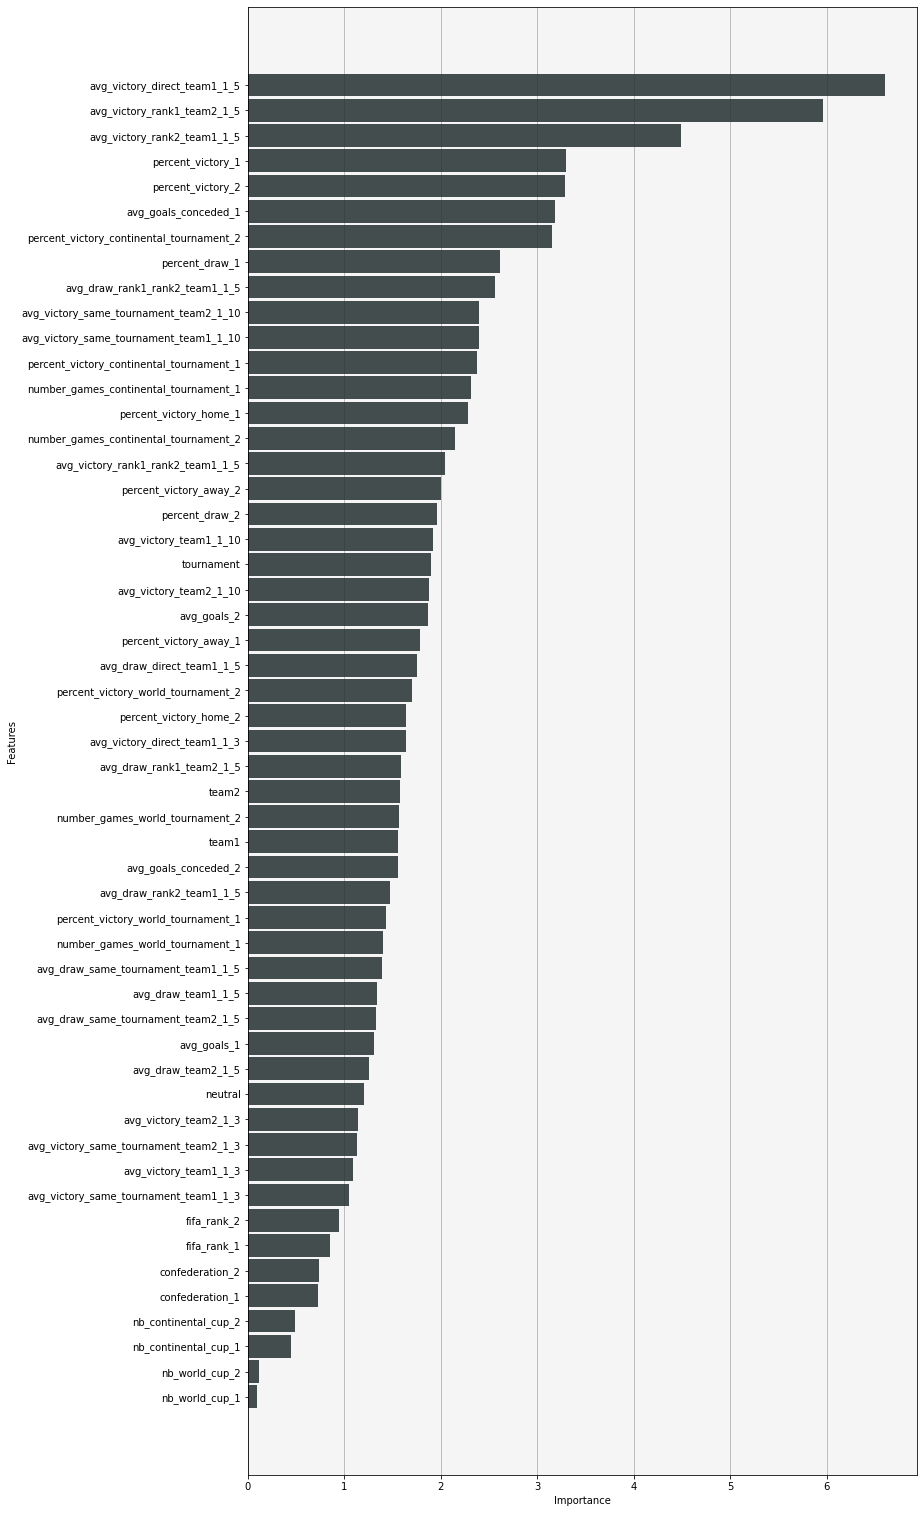

In [49]:
x = model.features_importance()

Let's add the predictions to the vDataFrame. As the draw is very rare, we will consider the draw only if its probability is very high and the probability that team1 wins is close to the one of team2. 

In [50]:
test = vDataFrame("football_test")
model.predict(test, name = "prob_1", pos_label = "1")
model.predict(test, name = "prob_X", pos_label = "X")
model.predict(test, name = "prob_2", pos_label = "2")
test.case_when(name = "prediction",
               conditions = {"prob_1 > prob_2 + 0.05": "1",
                             "prob_2 > prob_1 + 0.05": "2",
                             "prob_X > prob_1 AND prob_X > prob_2": "X",
                             "ABS(prob_1 - prob_2) < 0.03": "X",
                             "prob_1 > prob_2": "1",
                             "prob_1 < prob_2": "2"})

,avg_victory_team2_1_3,Percent_Victory_World_Tournament_1,avg_victory_same_tournament_team2_1_10,fifa_rank_1,Percent_Draw_1,Number_Games_Continental_Tournament_2,avg_victory_same_tournament_team2_1_3,team2,avg_victory_team1_1_3,Percent_Victory_Home_1,avg_draw_direct_team1_1_5,avg_victory_team1_1_10,Number_Games_Continental_Tournament_1,nb_World_Cup_2,Percent_Victory_Continental_Tournament_2,nb_Continental_Cup_1,neutral,date,Percent_Victory_2,nb_World_Cup_1,avg_draw_team1_1_5,avg_draw_same_tournament_team2_1_5,victory_team2,nb_Continental_Cup_2,match_sample,Avg_goals_conceded_2,Percent_Victory_Away_1,confederation_2,avg_victory_rank1_rank2_team1_1_5,avg_victory_team2_1_10,Avg_goals_1,Percent_Victory_Home_2,avg_draw_same_tournament_team1_1_5,avg_draw_team2_1_5,Number_Games_World_Tournament_1,avg_victory_rank1_team2_1_5,avg_victory_same_tournament_team1_1_10,team1_score,avg_victory_same_tournament_team1_1_3,avg_victory_direct_team1_1_3,Number_Games_World_Tournament_2,Percent_Victory_World_Tournament_2,result,Avg_goals_conceded_1,city,draw,avg_draw_rank1_rank2_team1_1_5,Percent_Victory_Away_2,avg_draw_rank2_team1_1_5,avg_draw_rank1_team2_1_5,country,team1,tournament,Percent_Draw_2,confederation_1,avg_victory_rank2_team1_1_5,Percent_Victory_1,avg_victory_direct_team1_1_5,Avg_goals_2,team2_score,fifa_rank_2,Percent_Victory_Continental_Tournament_1,victory_team1,prob_1,prob_X,prob_2,prediction
0,0.0,None,0.0,None,None,None,0.0,Chagos Islands,0.0,None,0.0,0.0,None,None,None,None,0,2016-08-26,None,None,0.0,0.0,1,None,1,None,None,None,1.0,0.0,None,None,0.0,0.0,None,None,0.0,2,0.0,1.0,None,None,2,None,London,0,0.0,None,None,None,England,Barawa,World Unity Cup,None,None,None,None,1.0,None,3,None,None,0,None,None,None,None
1,0.5,None,0.5,None,None,None,0.5,Chagos Islands,0.0,None,0.0,0.0,None,None,None,None,0,2018-04-08,None,None,0.0,0.0,0,None,1,None,None,None,0.333333333333333,0.5,None,None,0.0,0.0,None,1.0,0.0,4,0.0,0.0,None,None,1,None,London,0,0.0,None,0.0,0.0,England,Barawa,Friendly,None,None,0.0,None,0.0,None,1,None,None,1,None,None,None,None
2,0.0,None,0.0,None,None,None,0.0,Western Armenia,0.0,None,0.2,0.2,None,None,None,None,1,2018-05-31,None,None,0.4,0.333333333333333,0,None,1,None,None,None,0.4,0.0,None,None,0.4,0.333333333333333,None,None,0.2,0,0.0,0.4,None,None,X,None,Carshalton,1,0.2,None,None,None,England,United Koreans in Japan,CONIFA World Football Cup,None,None,None,None,0.4,None,0,None,None,0,None,None,None,None
3,0.0,None,0.25,None,None,None,0.0,Panjab,0.666666666666667,None,0.0,0.5,None,None,None,None,0,2018-06-07,None,None,0.0,0.25,1,None,1,None,None,None,0.2,0.25,None,None,0.0,0.25,None,None,0.666666666666667,0,0.666666666666667,0.5,None,None,2,None,Sutton,0,0.4,None,0.0,None,England,Barawa,CONIFA World Football Cup,None,None,0.5,None,0.5,None,5,None,None,0,None,None,None,None
4,0.0,None,0.0,None,None,None,0.0,Western Armenia,0.333333333333333,None,0.0,0.428571428571429,None,None,None,None,0,2018-06-09,None,None,0.0,0.5,1,None,1,None,None,None,0.4,0.0,None,None,0.0,0.5,None,0.0,0.5,0,0.333333333333333,0.333333333333333,None,None,2,None,Haringey,0,0.4,None,0.0,1.0,England,Barawa,CONIFA World Football Cup,None,None,0.333333333333333,None,0.333333333333333,None,7,None,None,0,None,None,None,None
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


<object>  Name: football_test, Number of rows: 3884, Number of columns: 67

Let's look at our predictions in the World Cup 2018 !

In [51]:
test.search(conditions = ["tournament = 'FIFA World Cup'"], 
            usecols = ["date",
                       "team1", 
                       "result", 
                       "prediction", 
                       "team2", 
                       "prob_1", 
                       "prob_X", 
                       "prob_2"],
            order_by = ["date"]).head(128)

,date,team1,result,prediction,team2,prob_1,prob_X,prob_2
0,2018-06-14,Russia,1,1,Saudi Arabia,0.561589,0.244979,0.193432
1,2018-06-15,Portugal,X,2,Spain,0.19715,0.434092,0.368757
2,2018-06-15,Morocco,2,2,Iran,0.252763,0.356264,0.390973
3,2018-06-15,Egypt,2,2,Uruguay,0.205241,0.208153,0.586605
4,2018-06-16,Croatia,1,1,Nigeria,0.54273,0.156904,0.300367
5,2018-06-16,Peru,2,1,Denmark,0.403631,0.337083,0.259286
6,2018-06-16,France,1,1,Australia,0.656967,0.184006,0.159028
7,2018-06-16,Argentina,X,1,Iceland,0.696025,0.209708,0.0942668
8,2018-06-17,Germany,2,1,Mexico,0.639551,0.154599,0.205849
9,2018-06-17,Brazil,X,1,Switzerland,0.570329,0.215157,0.214514


<object>  Name: search, Number of rows: 64, Number of columns: 8

Fantastic: We built a very efficient model which predicted that France will win almost all of its games (except a draw against the Belgium) and they really won the World Cup !

In [52]:
test.search(conditions = ["tournament = 'FIFA World Cup'",
                          "team1 = 'France' OR team2 = 'France'"], 
            usecols = ["date",
                       "team1", 
                       "result", 
                       "prediction", 
                       "team2", 
                       "prob_1", 
                       "prob_X", 
                       "prob_2"],
            order_by = ["date"]).head(128)

,date,team1,result,prediction,team2,prob_1,prob_X,prob_2
0,2018-06-16,France,1,1,Australia,0.656967,0.184006,0.159028
1,2018-06-21,France,1,1,Peru,0.554147,0.290328,0.155526
2,2018-06-26,Denmark,X,2,France,0.272388,0.24435,0.483262
3,2018-06-30,France,1,1,Argentina,0.45777,0.290343,0.251887
4,2018-07-06,Uruguay,2,2,France,0.371976,0.192809,0.435215
5,2018-07-10,France,1,1,Belgium,0.475845,0.282771,0.241384
6,2018-07-15,France,1,1,Croatia,0.445087,0.245477,0.309436


<object>  Name: search, Number of rows: 7, Number of columns: 8

## Conclusion

We have solved this use-case in a pandas-like way but we never loaded the data in memory. This example showed an overview of the library. You can now start your own project by looking at the documentation first.